In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb
from sklearn.metrics import r2_score

In [2]:
numCores = 20
numBestFitIters = 5
numSims = 100
ts = np.linspace(0,30,100)

In [3]:
data,lacE,glycolysis,fluxes,conc,labeled_contributions = generateSyntheticData(ts)
print(conc)
conc = {key:val for key,val in conc.items() if key != "NADH"}
data

{'Lactate': 0.18225651995238434, 'G3P': 0.74353941459214, 'Malate': 0.06958208096995455, 'NADH': 0.8853372043807507}


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.975490,0.990217,0.986222,0.956301,0.830381,0.024510,0.013778,0.043699,0.169619,0.009549,0.000235
2,0.928224,0.968882,0.966855,0.896707,0.744015,0.071776,0.033145,0.103293,0.255985,0.029526,0.001592
3,0.884467,0.943660,0.952818,0.854680,0.700041,0.115533,0.047182,0.145320,0.299959,0.052092,0.004248
4,0.855192,0.918906,0.944363,0.829625,0.677650,0.144808,0.055637,0.170375,0.322350,0.073493,0.007601
...,...,...,...,...,...,...,...,...,...,...,...
95,0.818076,0.786315,0.934381,0.800244,0.654423,0.181924,0.065619,0.199756,0.345577,0.182715,0.030970
96,0.818076,0.786315,0.934381,0.800244,0.654423,0.181924,0.065619,0.199756,0.345577,0.182715,0.030970
97,0.818076,0.786315,0.934381,0.800244,0.654423,0.181924,0.065619,0.199756,0.345577,0.182715,0.030970
98,0.818076,0.786315,0.934381,0.800244,0.654423,0.181924,0.065619,0.199756,0.345577,0.182715,0.030970


[0.91073217 0.44863288 0.32849674 0.57803612]
1.4174072686503791 8.417407242530615
[1.2908784  0.22714557 1.87686532 1.96236865]
{'Lactate': 0.18225651995238434, 'G3P': 0.74353941459214, 'Malate': 0.06958208096995455}


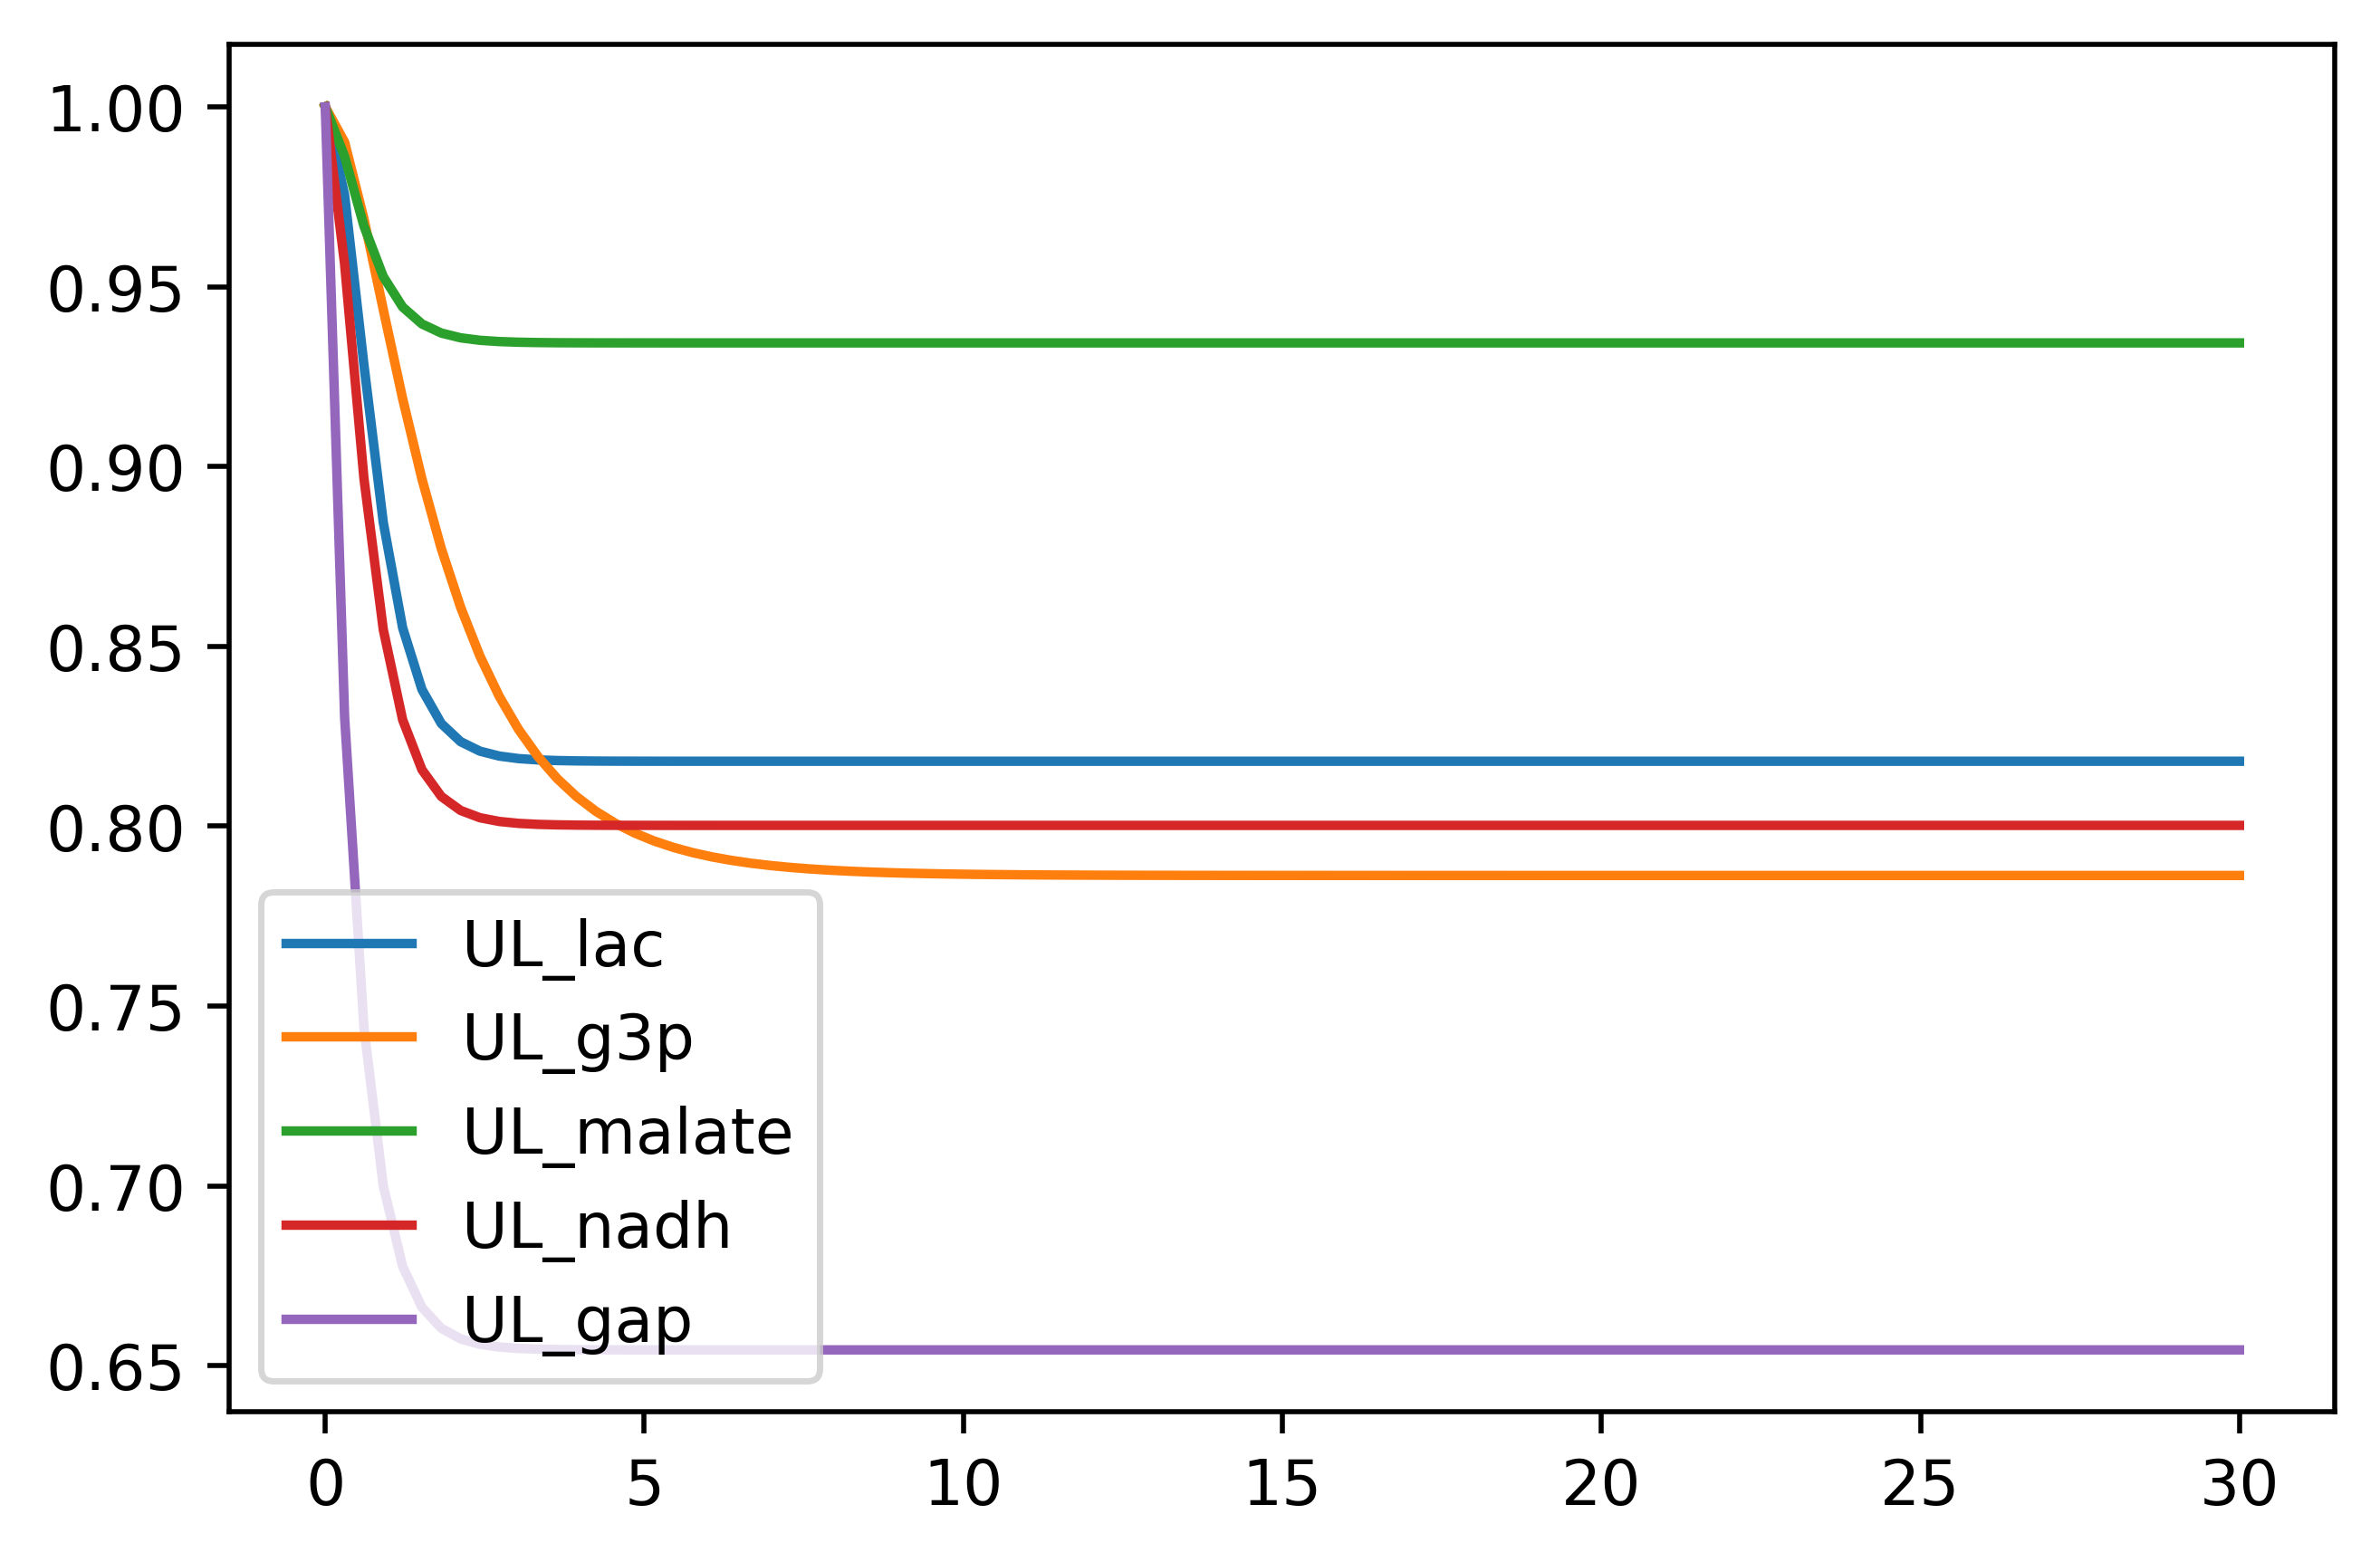

In [4]:
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh","UL_gap"]:
    plt.plot(ts,data[col],label=col)
plt.legend()
print(labeled_contributions)
print(lacE,glycolysis)
print(fluxes)
print(conc)

In [5]:
fluxes_inferred,labeled_contributions_inferred,df,conc,error = findFlux(data, ts, conc, lacE, glycolysis, np.array([0,0,0,0]))
print(fluxes_inferred)
print(labeled_contributions_inferred)
print(conc)
print(error)
df

[1.2909375 0.2270625 1.87775   2.2109375]
[0.91073217 0.44863287 0.32849674 0.57803612]
{'Lactate': 0.18225651995238434, 'G3P': 0.74353941459214, 'Malate': 0.06958208096995455, 'NADH': 1.0}
[2.88135522e-11 4.79284472e-11 3.85727944e-12 3.59607062e-11]


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2,L_g3p
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.975495,0.990209,0.986225,0.956312,0.830381,0.024505,0.013775,0.043688,0.169619,0.009549,0.000235,0.009791
2,0.928231,0.968867,0.966858,0.896715,0.744015,0.071769,0.033142,0.103285,0.255985,0.029526,0.001592,0.031133
3,0.884467,0.943643,0.952816,0.854676,0.700041,0.115533,0.047184,0.145324,0.299959,0.052092,0.004248,0.056357
4,0.855185,0.918892,0.944360,0.829614,0.677650,0.144815,0.055640,0.170386,0.322350,0.073493,0.007601,0.081108
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.818081,0.786321,0.934383,0.800250,0.654423,0.181919,0.065617,0.199750,0.345577,0.182715,0.030970,0.213679
96,0.818081,0.786321,0.934383,0.800250,0.654423,0.181919,0.065617,0.199750,0.345577,0.182715,0.030970,0.213679
97,0.818081,0.786321,0.934383,0.800250,0.654423,0.181919,0.065617,0.199750,0.345577,0.182715,0.030970,0.213679
98,0.818081,0.786321,0.934383,0.800250,0.654423,0.181919,0.065617,0.199750,0.345577,0.182715,0.030970,0.213679


In [9]:
dhap_params = fitSource(ts, data["UL_gap"])
dhap = lambda x: exponetialCurve(x,dhap_params)

    
firstT = np.min(ts)
firstT = [x for x in range(len(ts)) if abs(firstT-ts[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate","UL_nadh"],[conc["Lactate"],conc["G3P"],conc["Malate"],conc["NADH"]])]


nadh = interp1d(ts,
                integrateModel(nadhEquation,ts,(fluxes_inferred[3],conc['NADH'],(1-labeled_contributions_inferred[3])/labeled_contributions_inferred[3] * fluxes_inferred[3],None,dhap),initialState[3],conc["NADH"])[:,0],
                bounds_error=False,fill_value="extrapolate") 


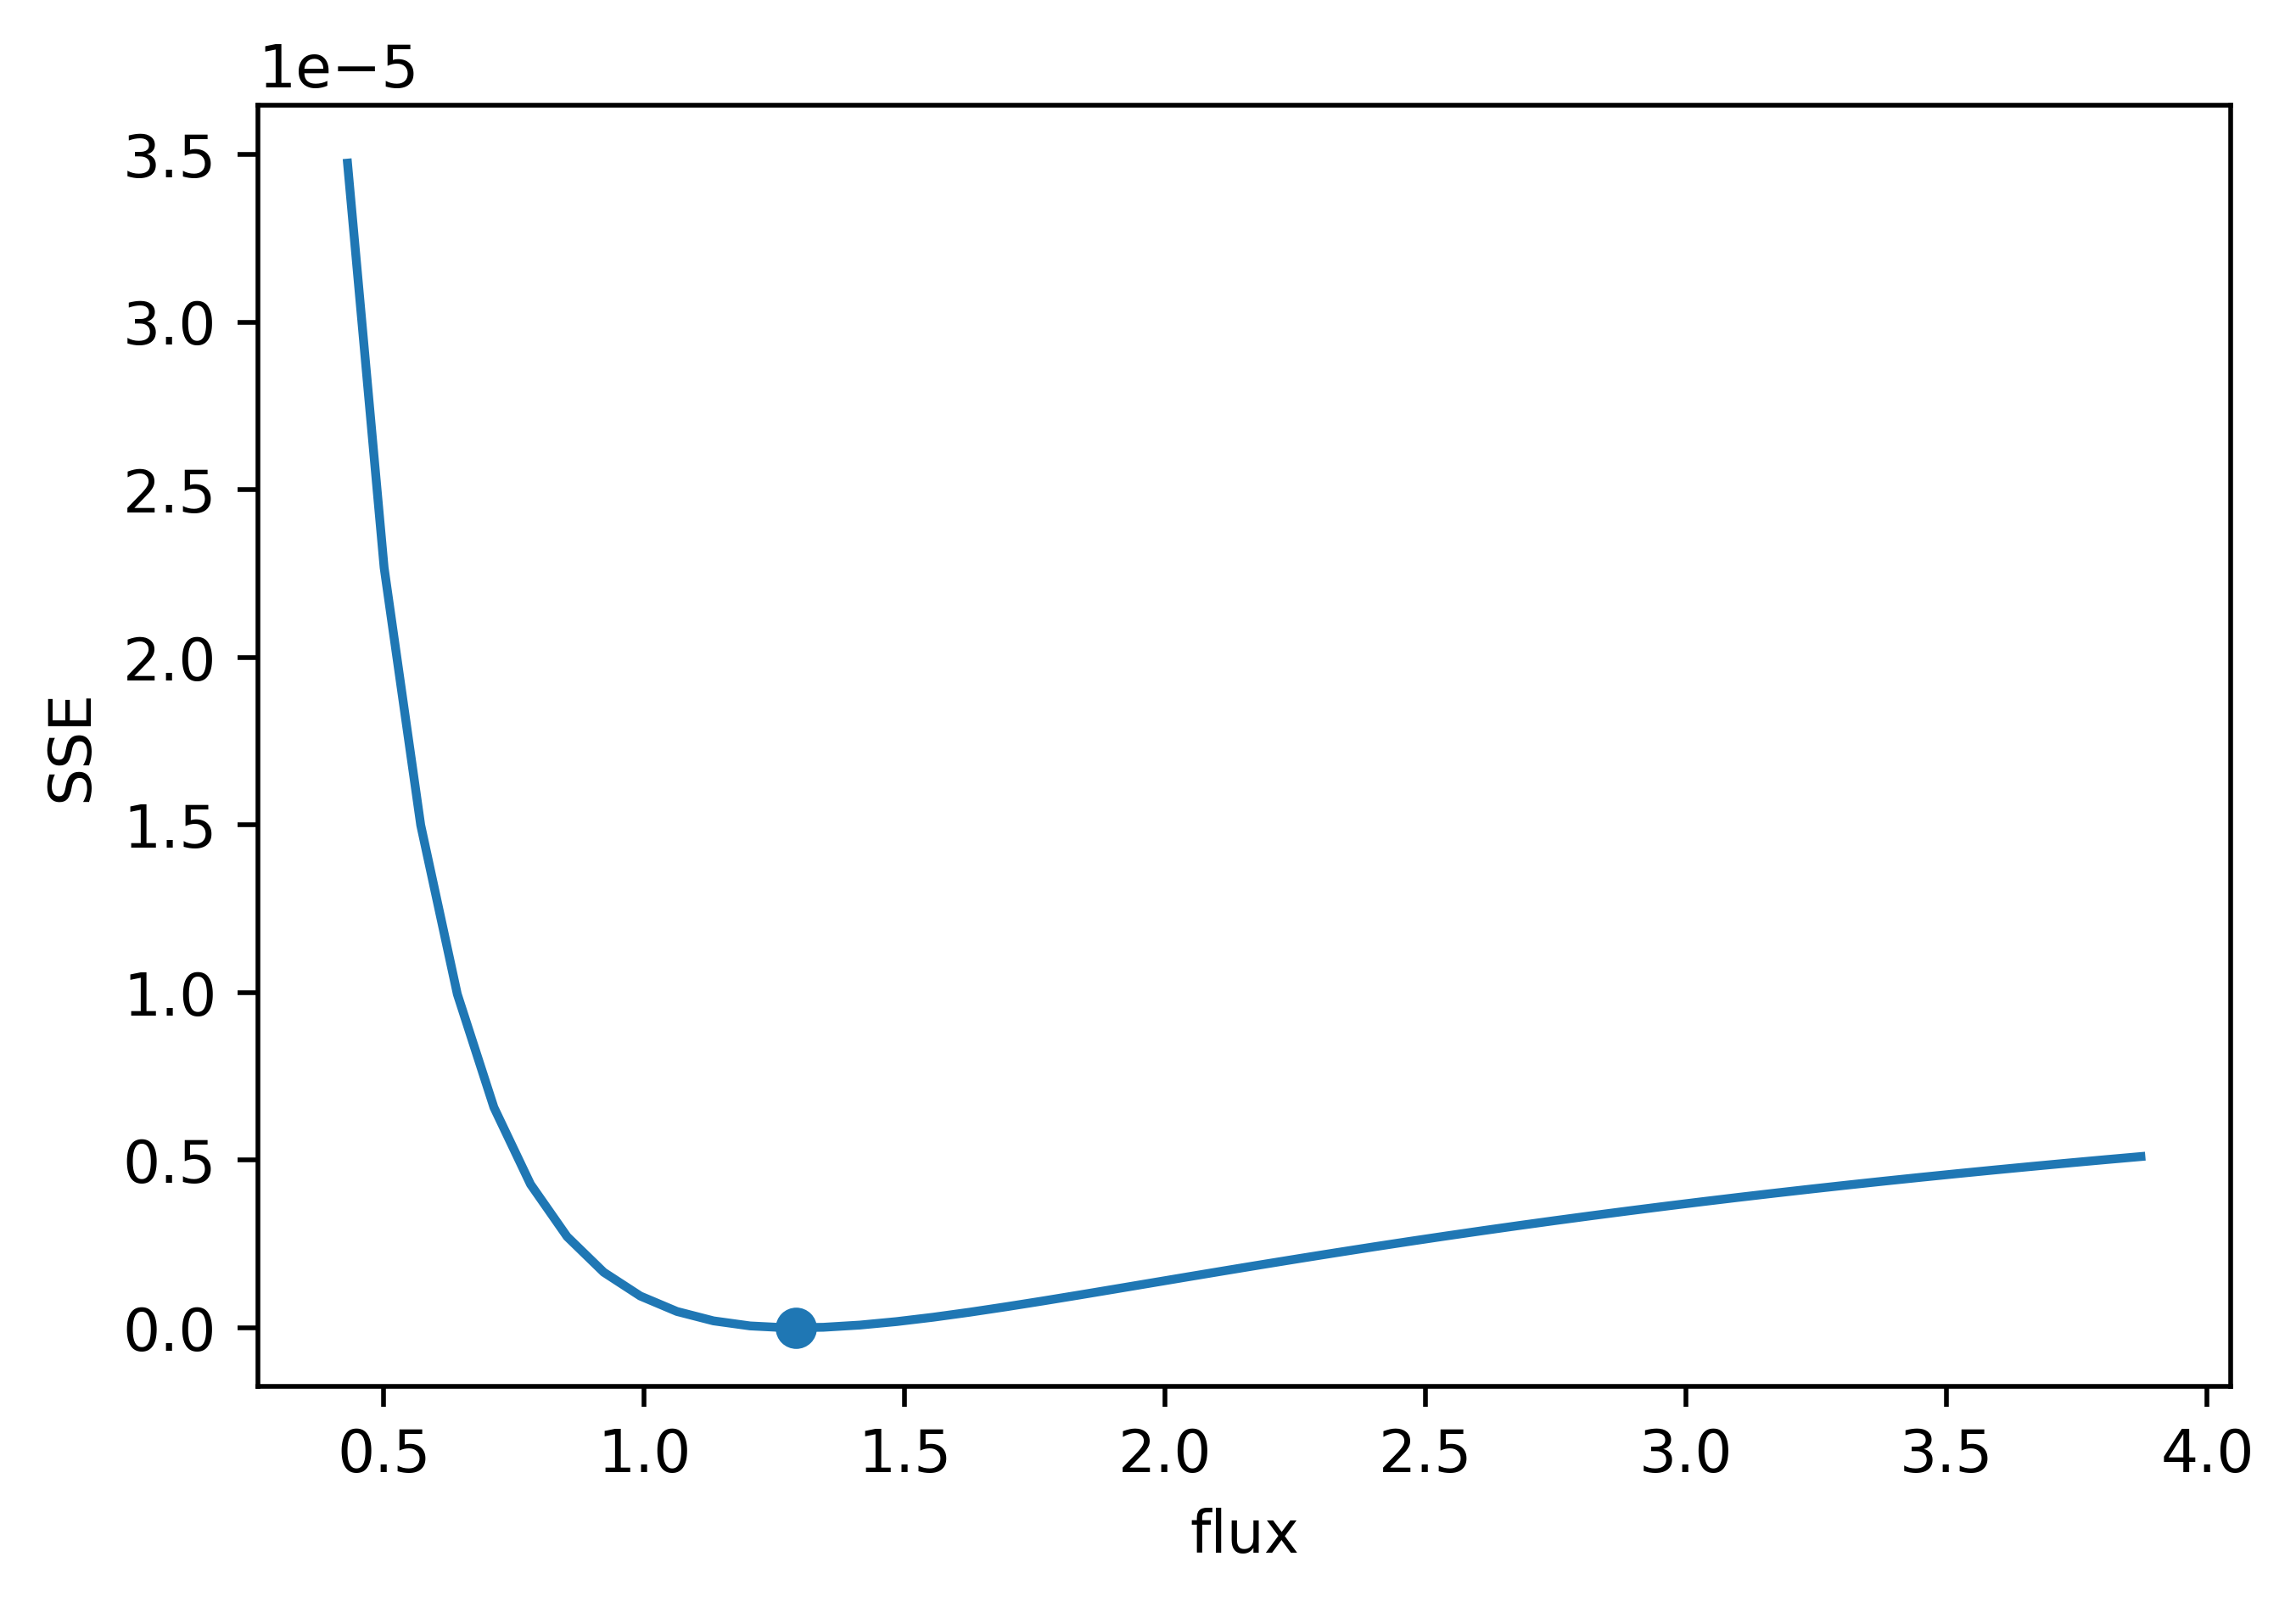

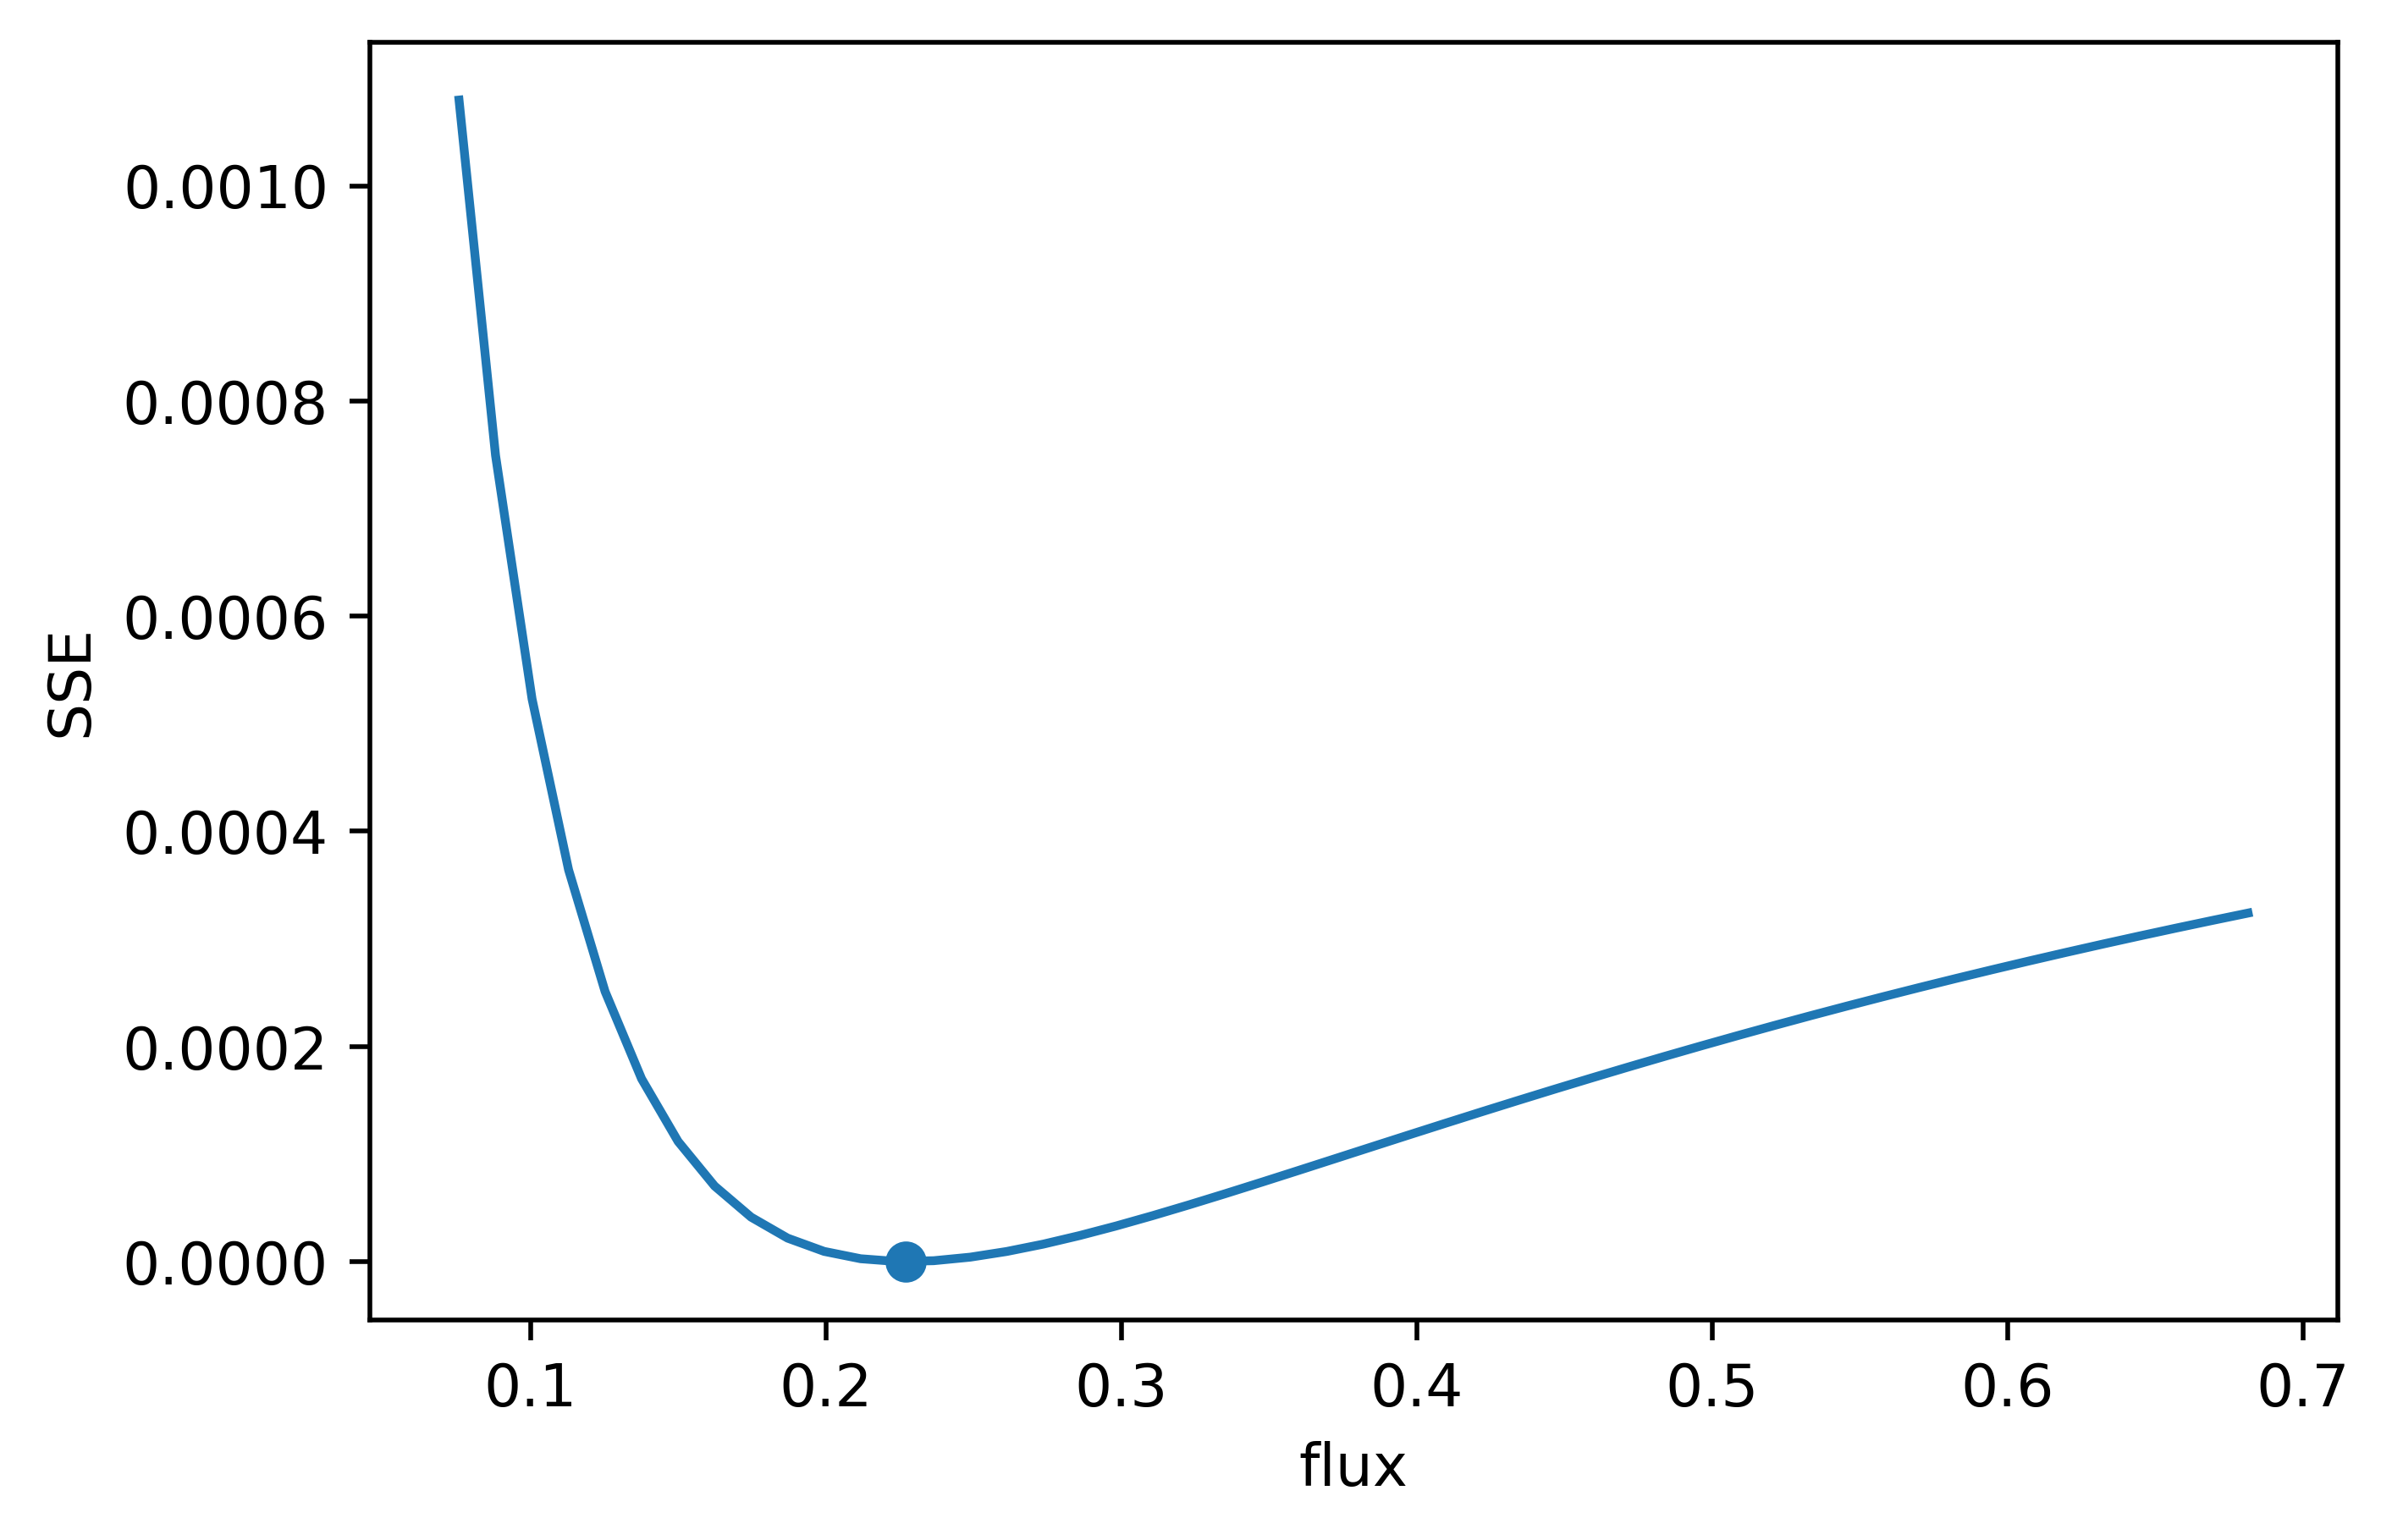

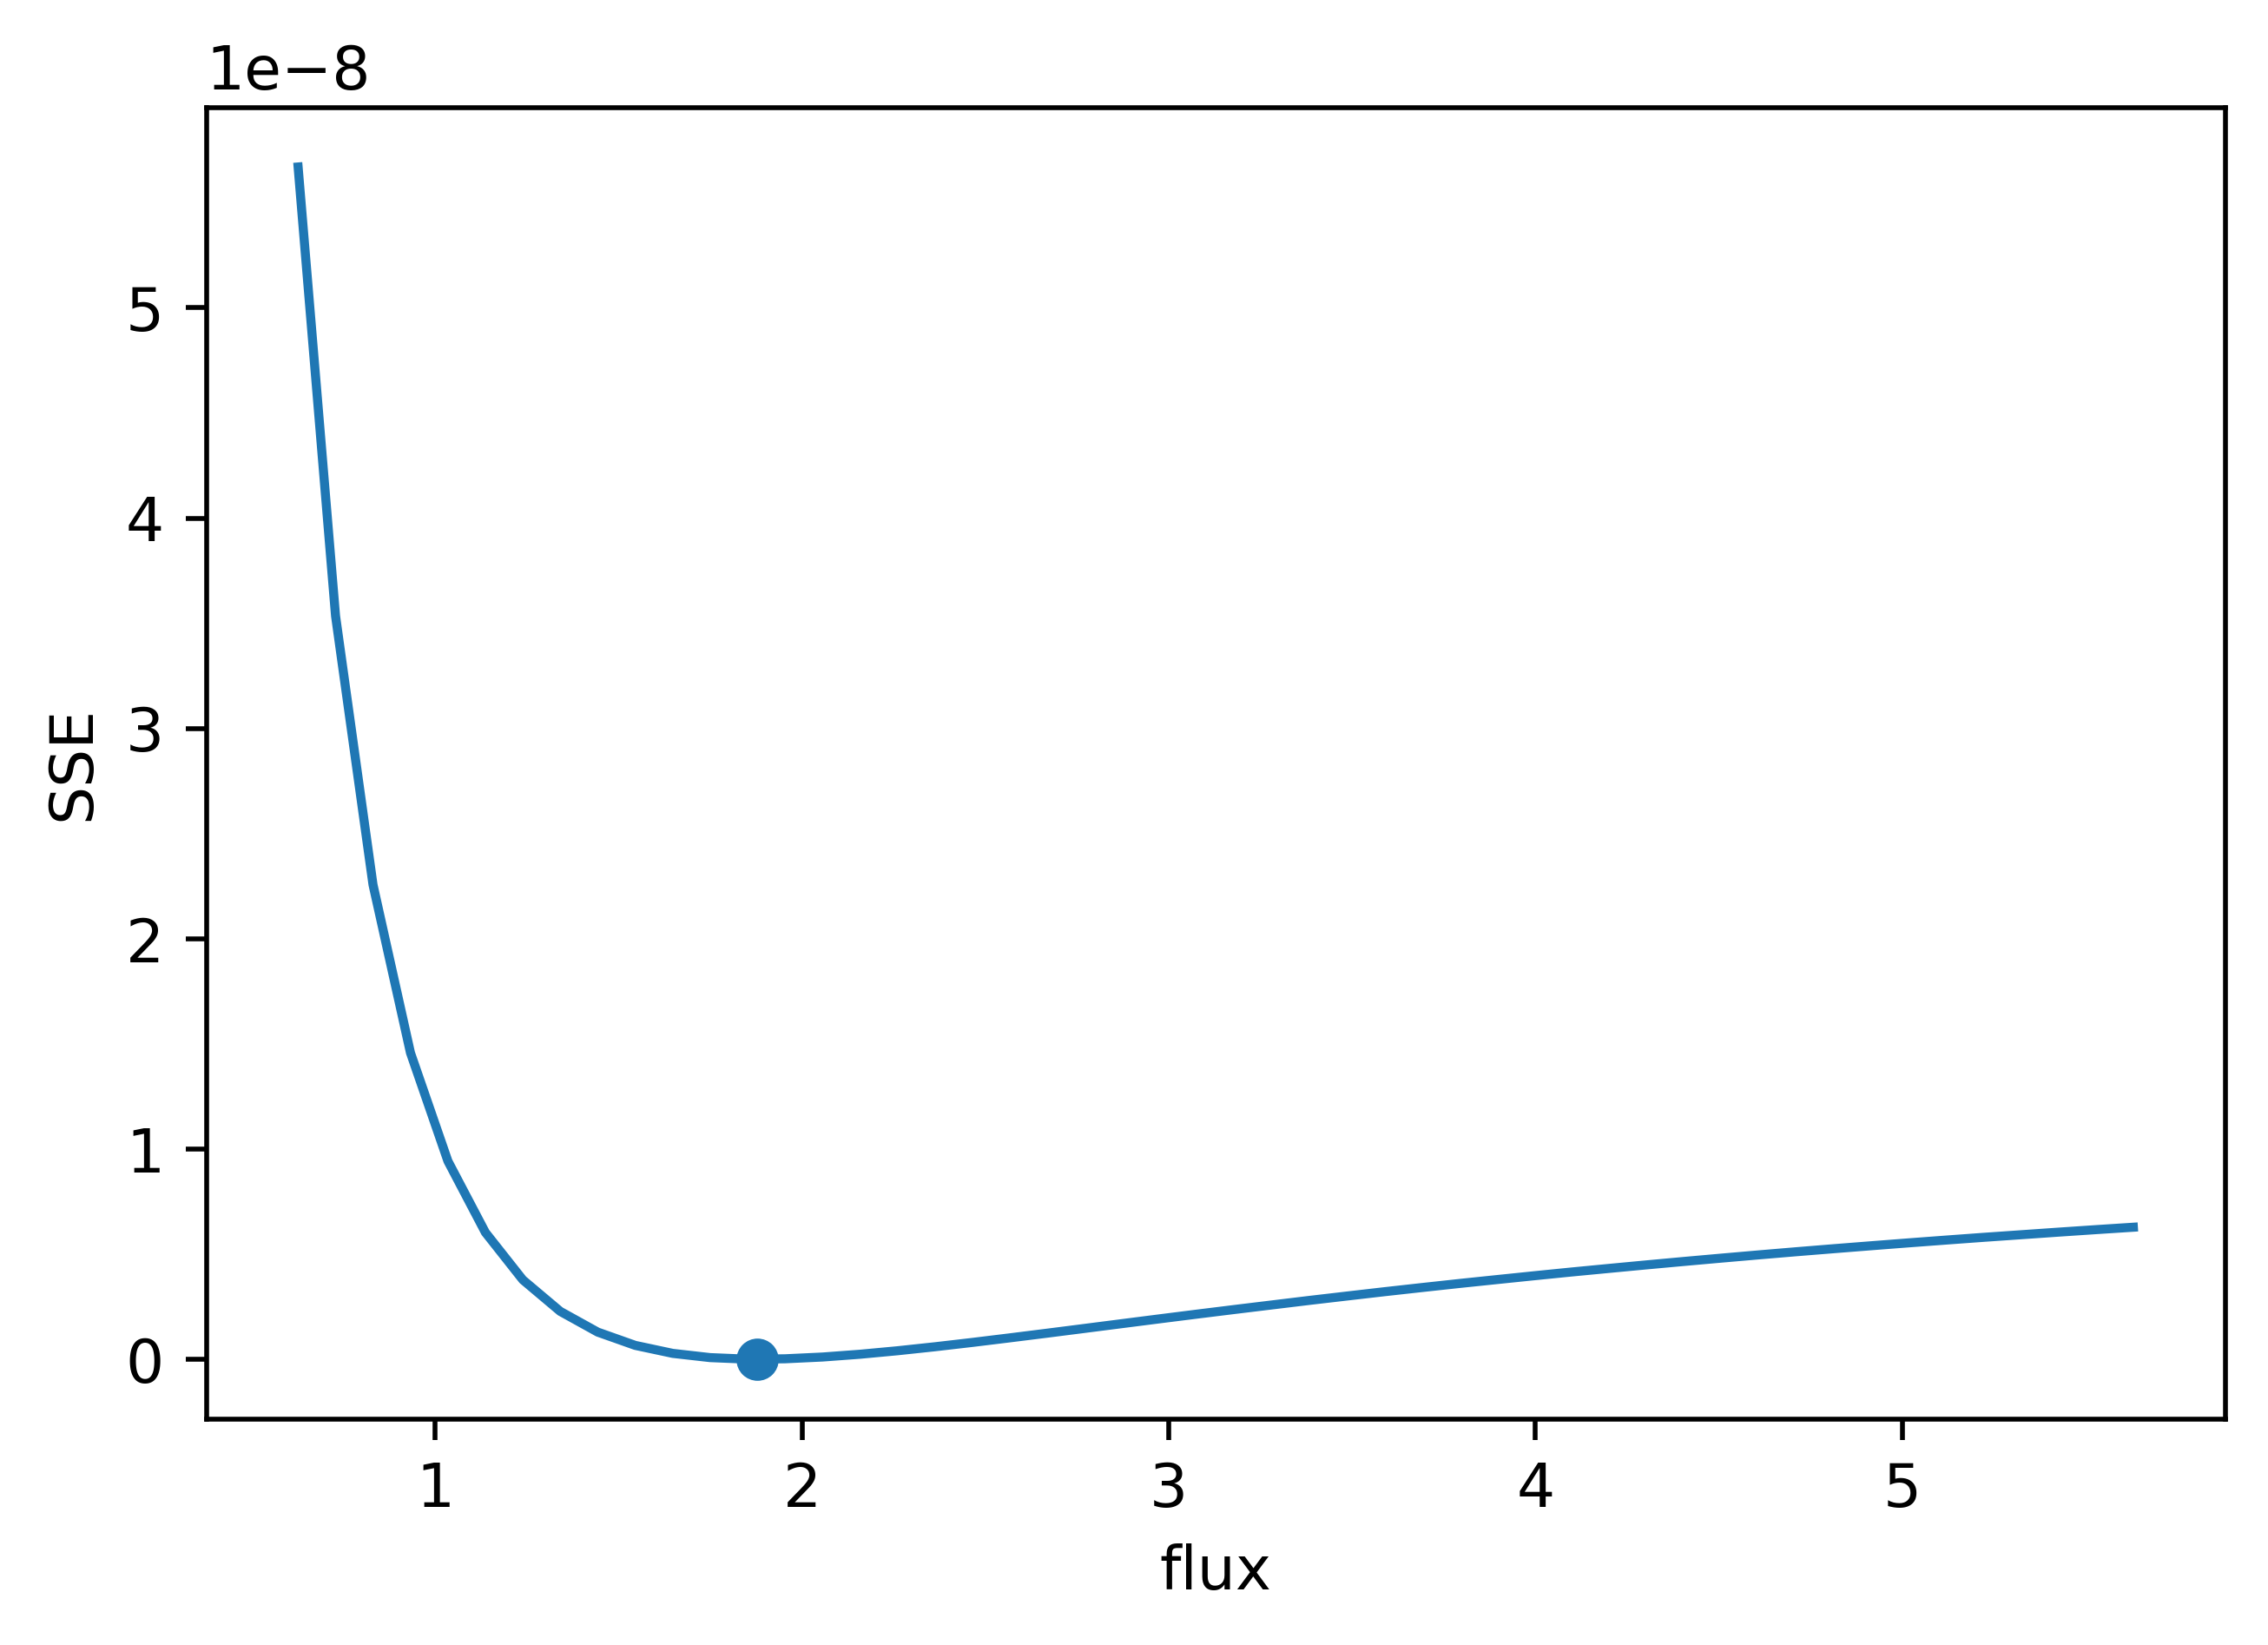

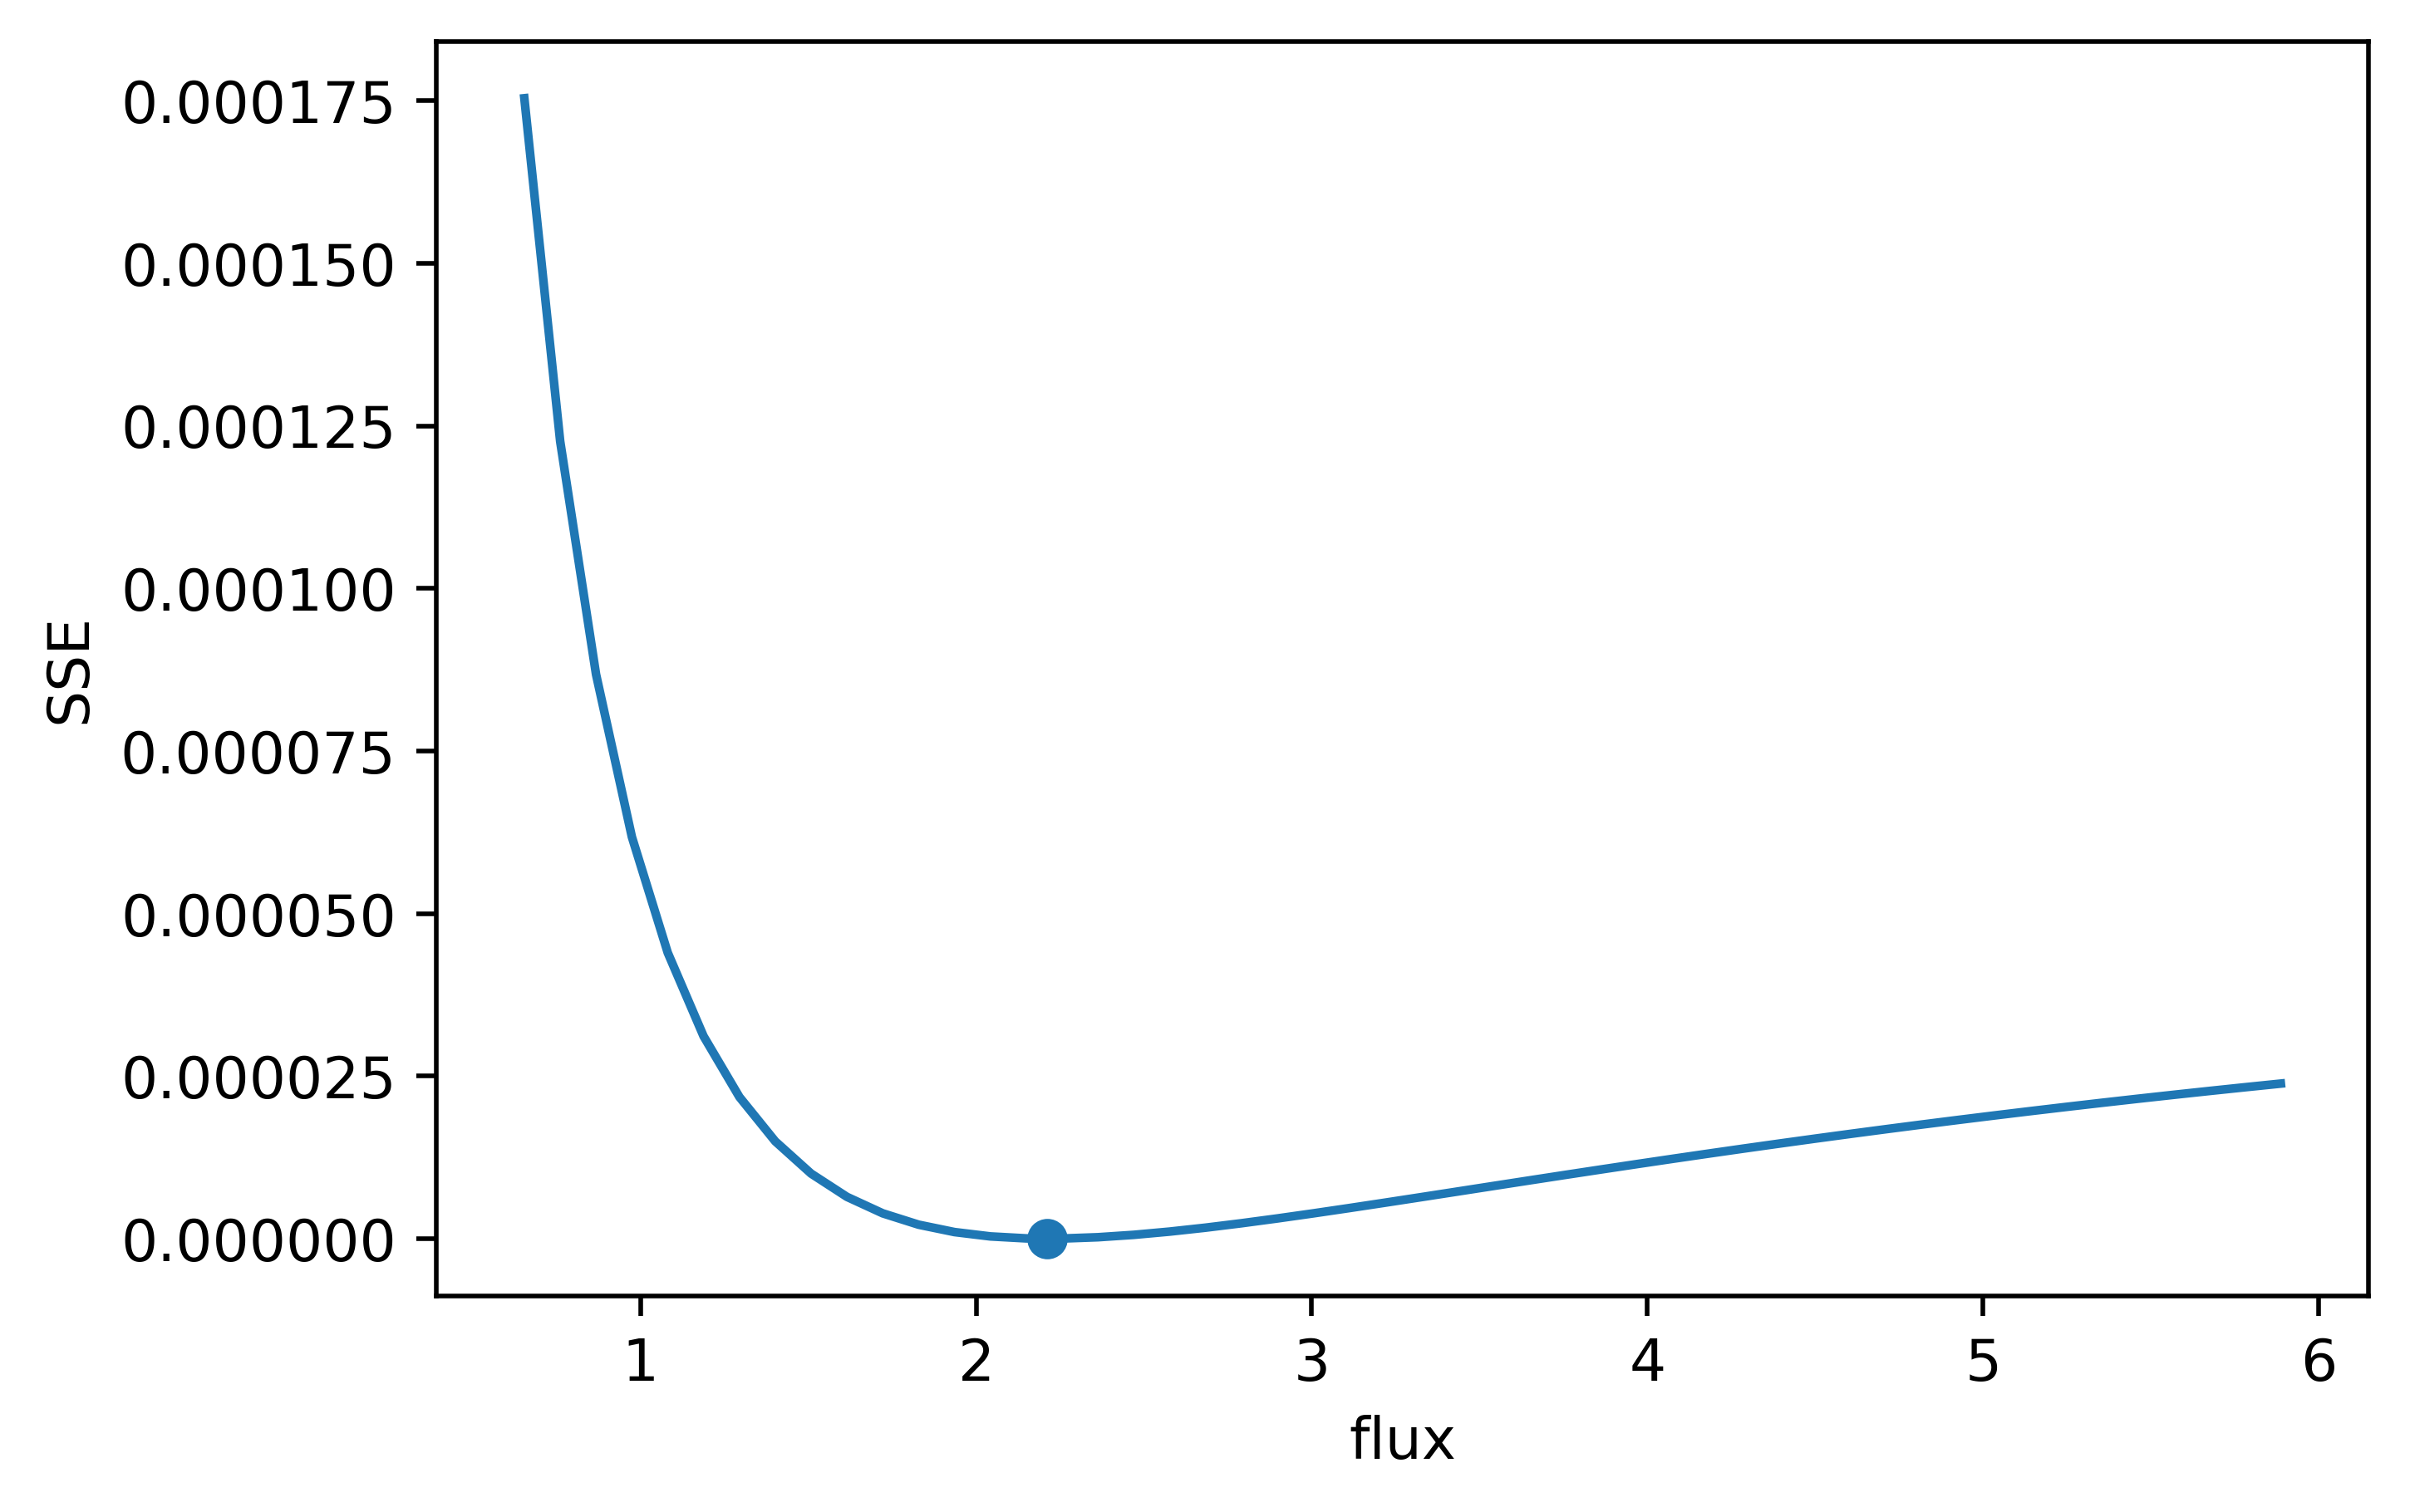

In [11]:
equations = [lactateEquation,g3pEquation,malateEquation,nadhEquation]
labels1 = ["UL_lac","UL_g3p","UL_malate","UL_nadh"]
labels2 = ["Lactate","G3P","Malate","NADH"]
for x in range(4):
    fluxes_to_try = np.linspace(fluxes[x]/3,3*fluxes[x])
    #fluxes_to_try = np.linspace(0,2*fluxes_inferred[x])
    errs = []
    for f in fluxes_to_try:
        val = integrateModel(equations[x],ts,(f,conc[labels2[x]],(1-labeled_contributions[x])/labeled_contributions[x] * f,nadh,dhap),initialState[x],conc[labels2[x]])[:,0]
        err = sse(val,data[labels1[x]].values)#np.sum(np.abs(val-data["UL_nadh"].values))
        errs.append(err)
    f = fluxes_inferred[x]
    val = integrateModel(equations[x],ts,(f,conc[labels2[x]],(1-labeled_contributions[x])/labeled_contributions[x] * f,nadh,dhap),initialState[x],conc[labels2[x]])[:,0]
    err = sse(val,data[labels1[x]].values)
    plt.figure()
    plt.plot(fluxes_to_try,errs)
    plt.ylabel("SSE")
    plt.xlabel("flux")
    plt.scatter([f],[err])
#plt.xlim((0,20000))

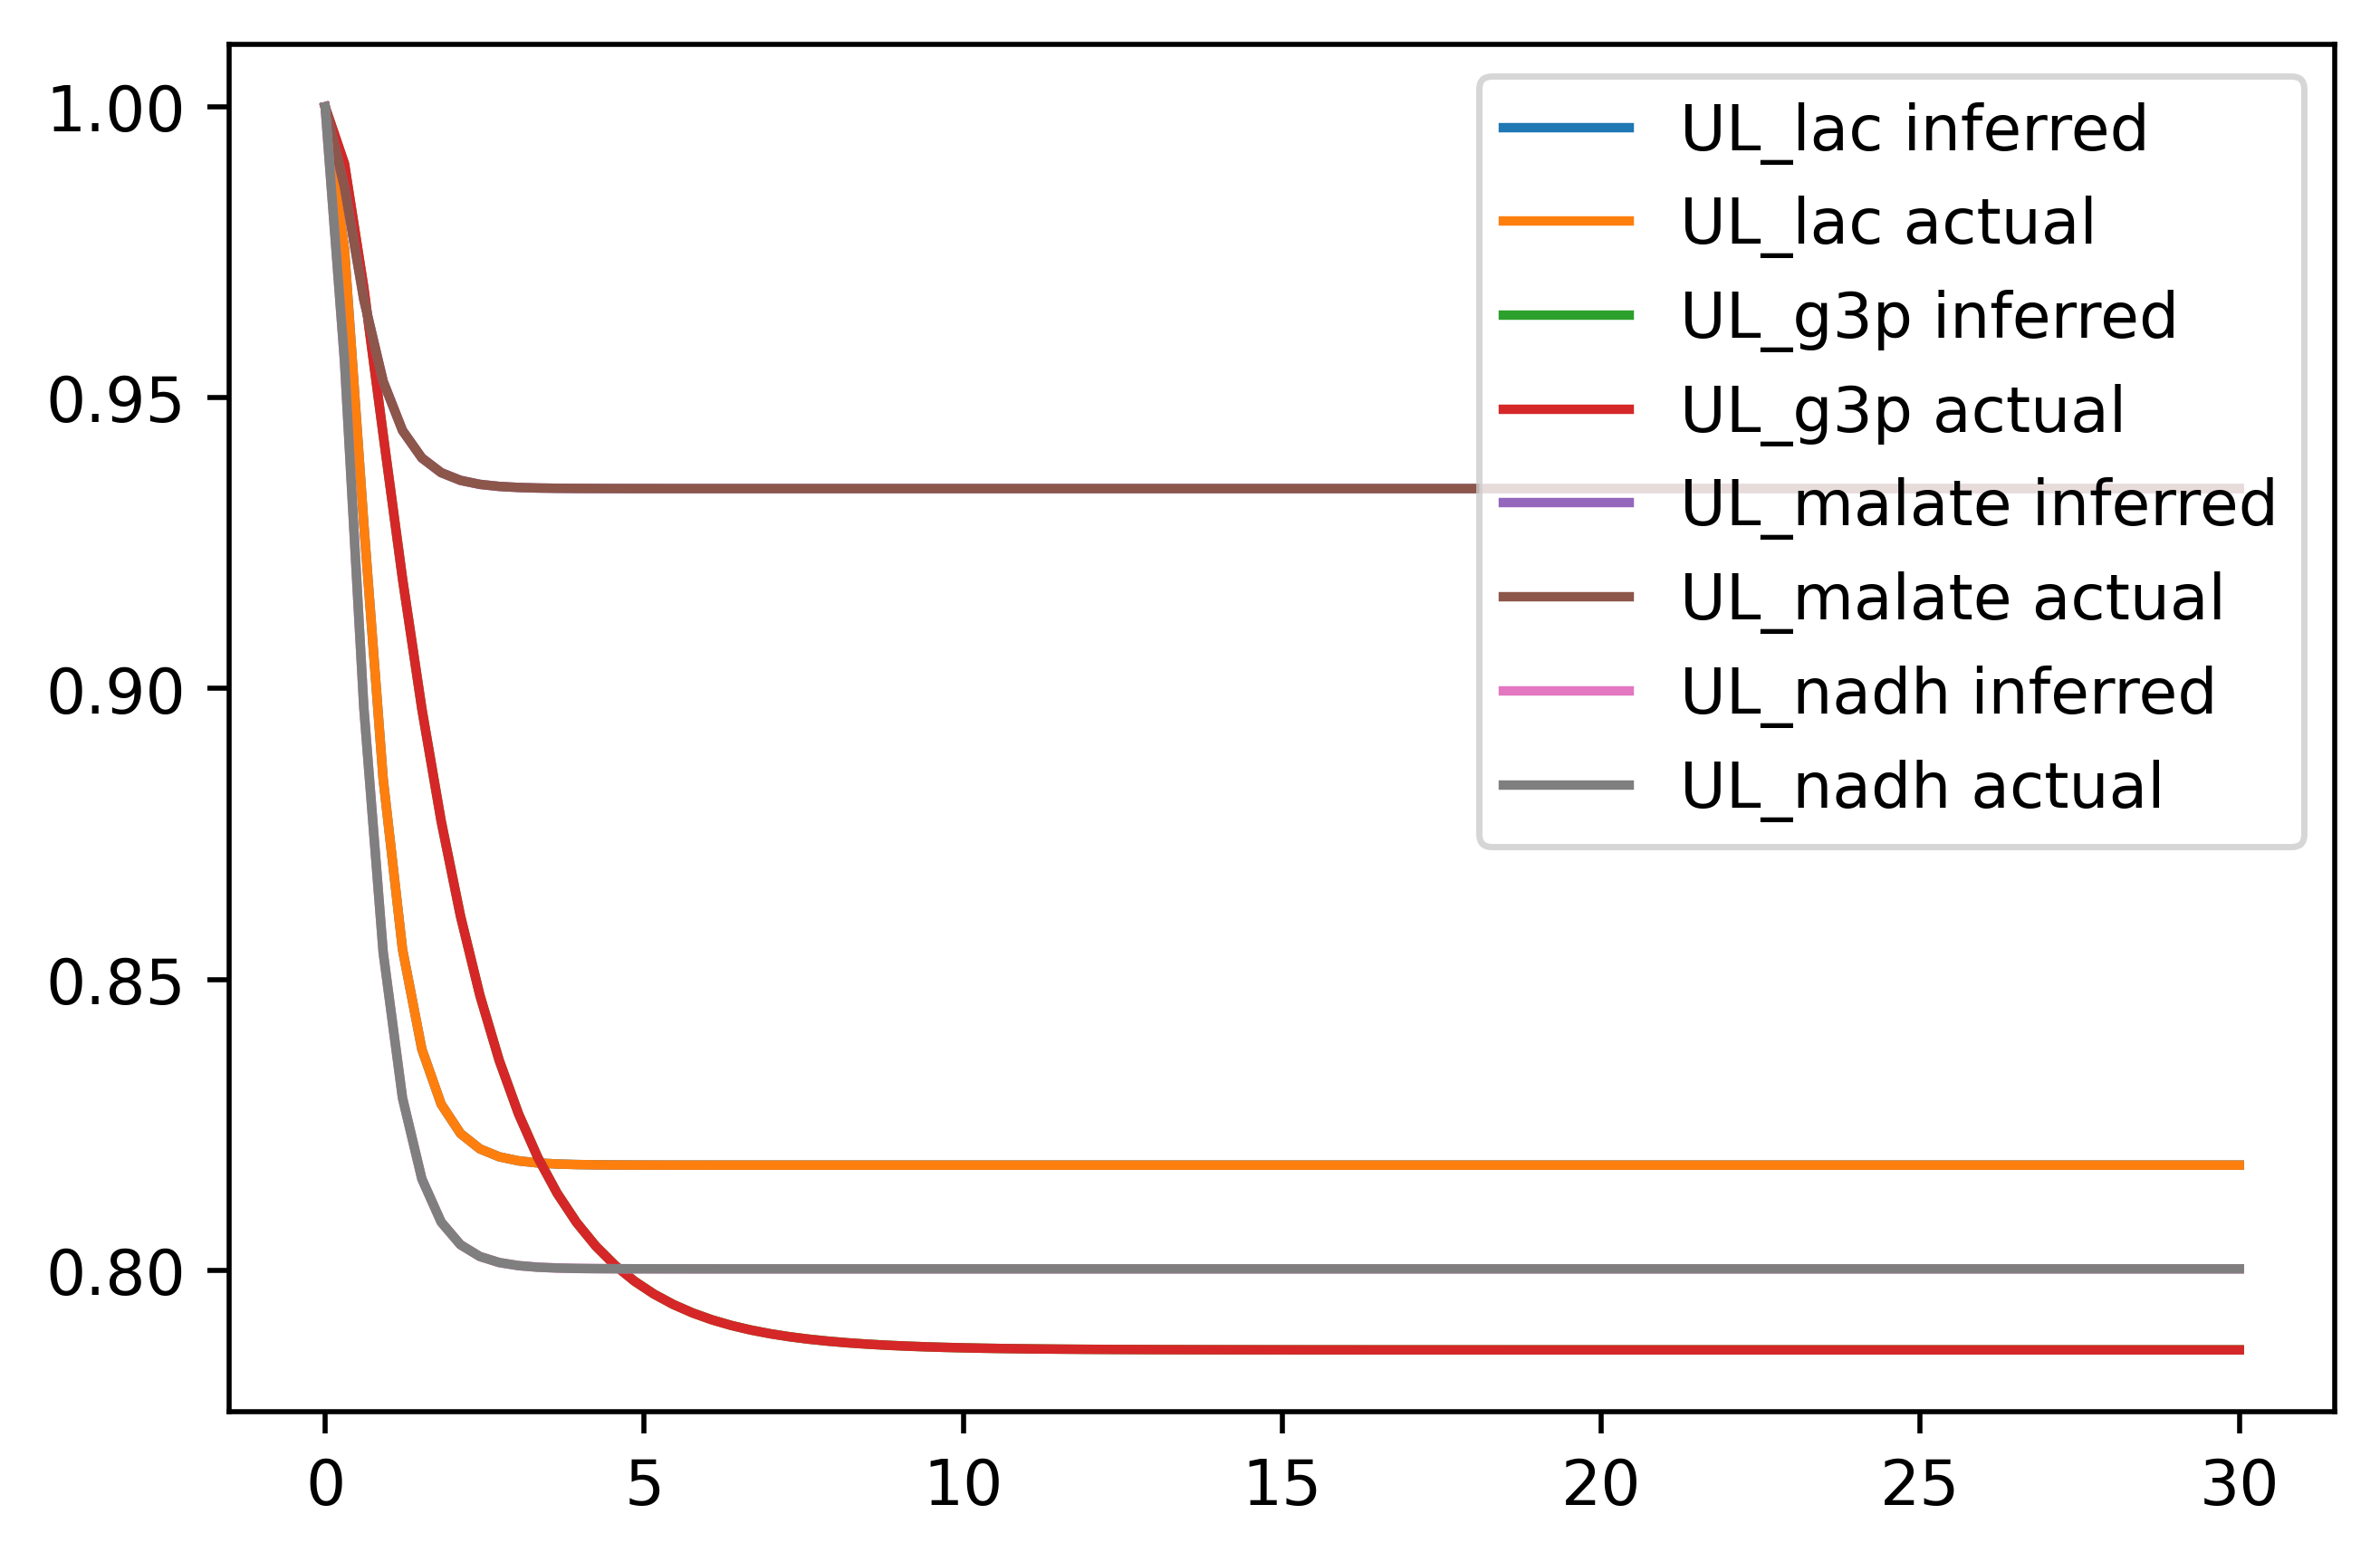

In [13]:
values = integrateLabelingModel(ts, fluxes_inferred,conc,dhap_params,labeled_contributions,initialState)
inferred = pd.DataFrame(data=values,columns=["UL_lac","UL_g3p","UL_malate","UL_nadh"])
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh"]:
    plt.plot(ts,inferred[col],label=col + " inferred")
    plt.plot(ts,data[col],label=col+" actual")
plt.legend()


In [ ]:
if __name__ == '__main__':
    true = []
    pred = []
    err = []
    args = [[ts,numBestFitIters] for _ in range(numSims)]
    result = startConcurrentTask(simulateDataAndInferFlux,args,numCores,"running simulations",len(args))
    for fluxes,(inferred_fluxes,_,_,conc,errs) in result:
        true.append(fluxes)
        pred.append(inferred_fluxes)
        err.append(errs)
true = np.array(true)
pred = np.array(pred)
err = np.array(err)

running simulations |████████████████████████████████████████████████--| 97.0% 

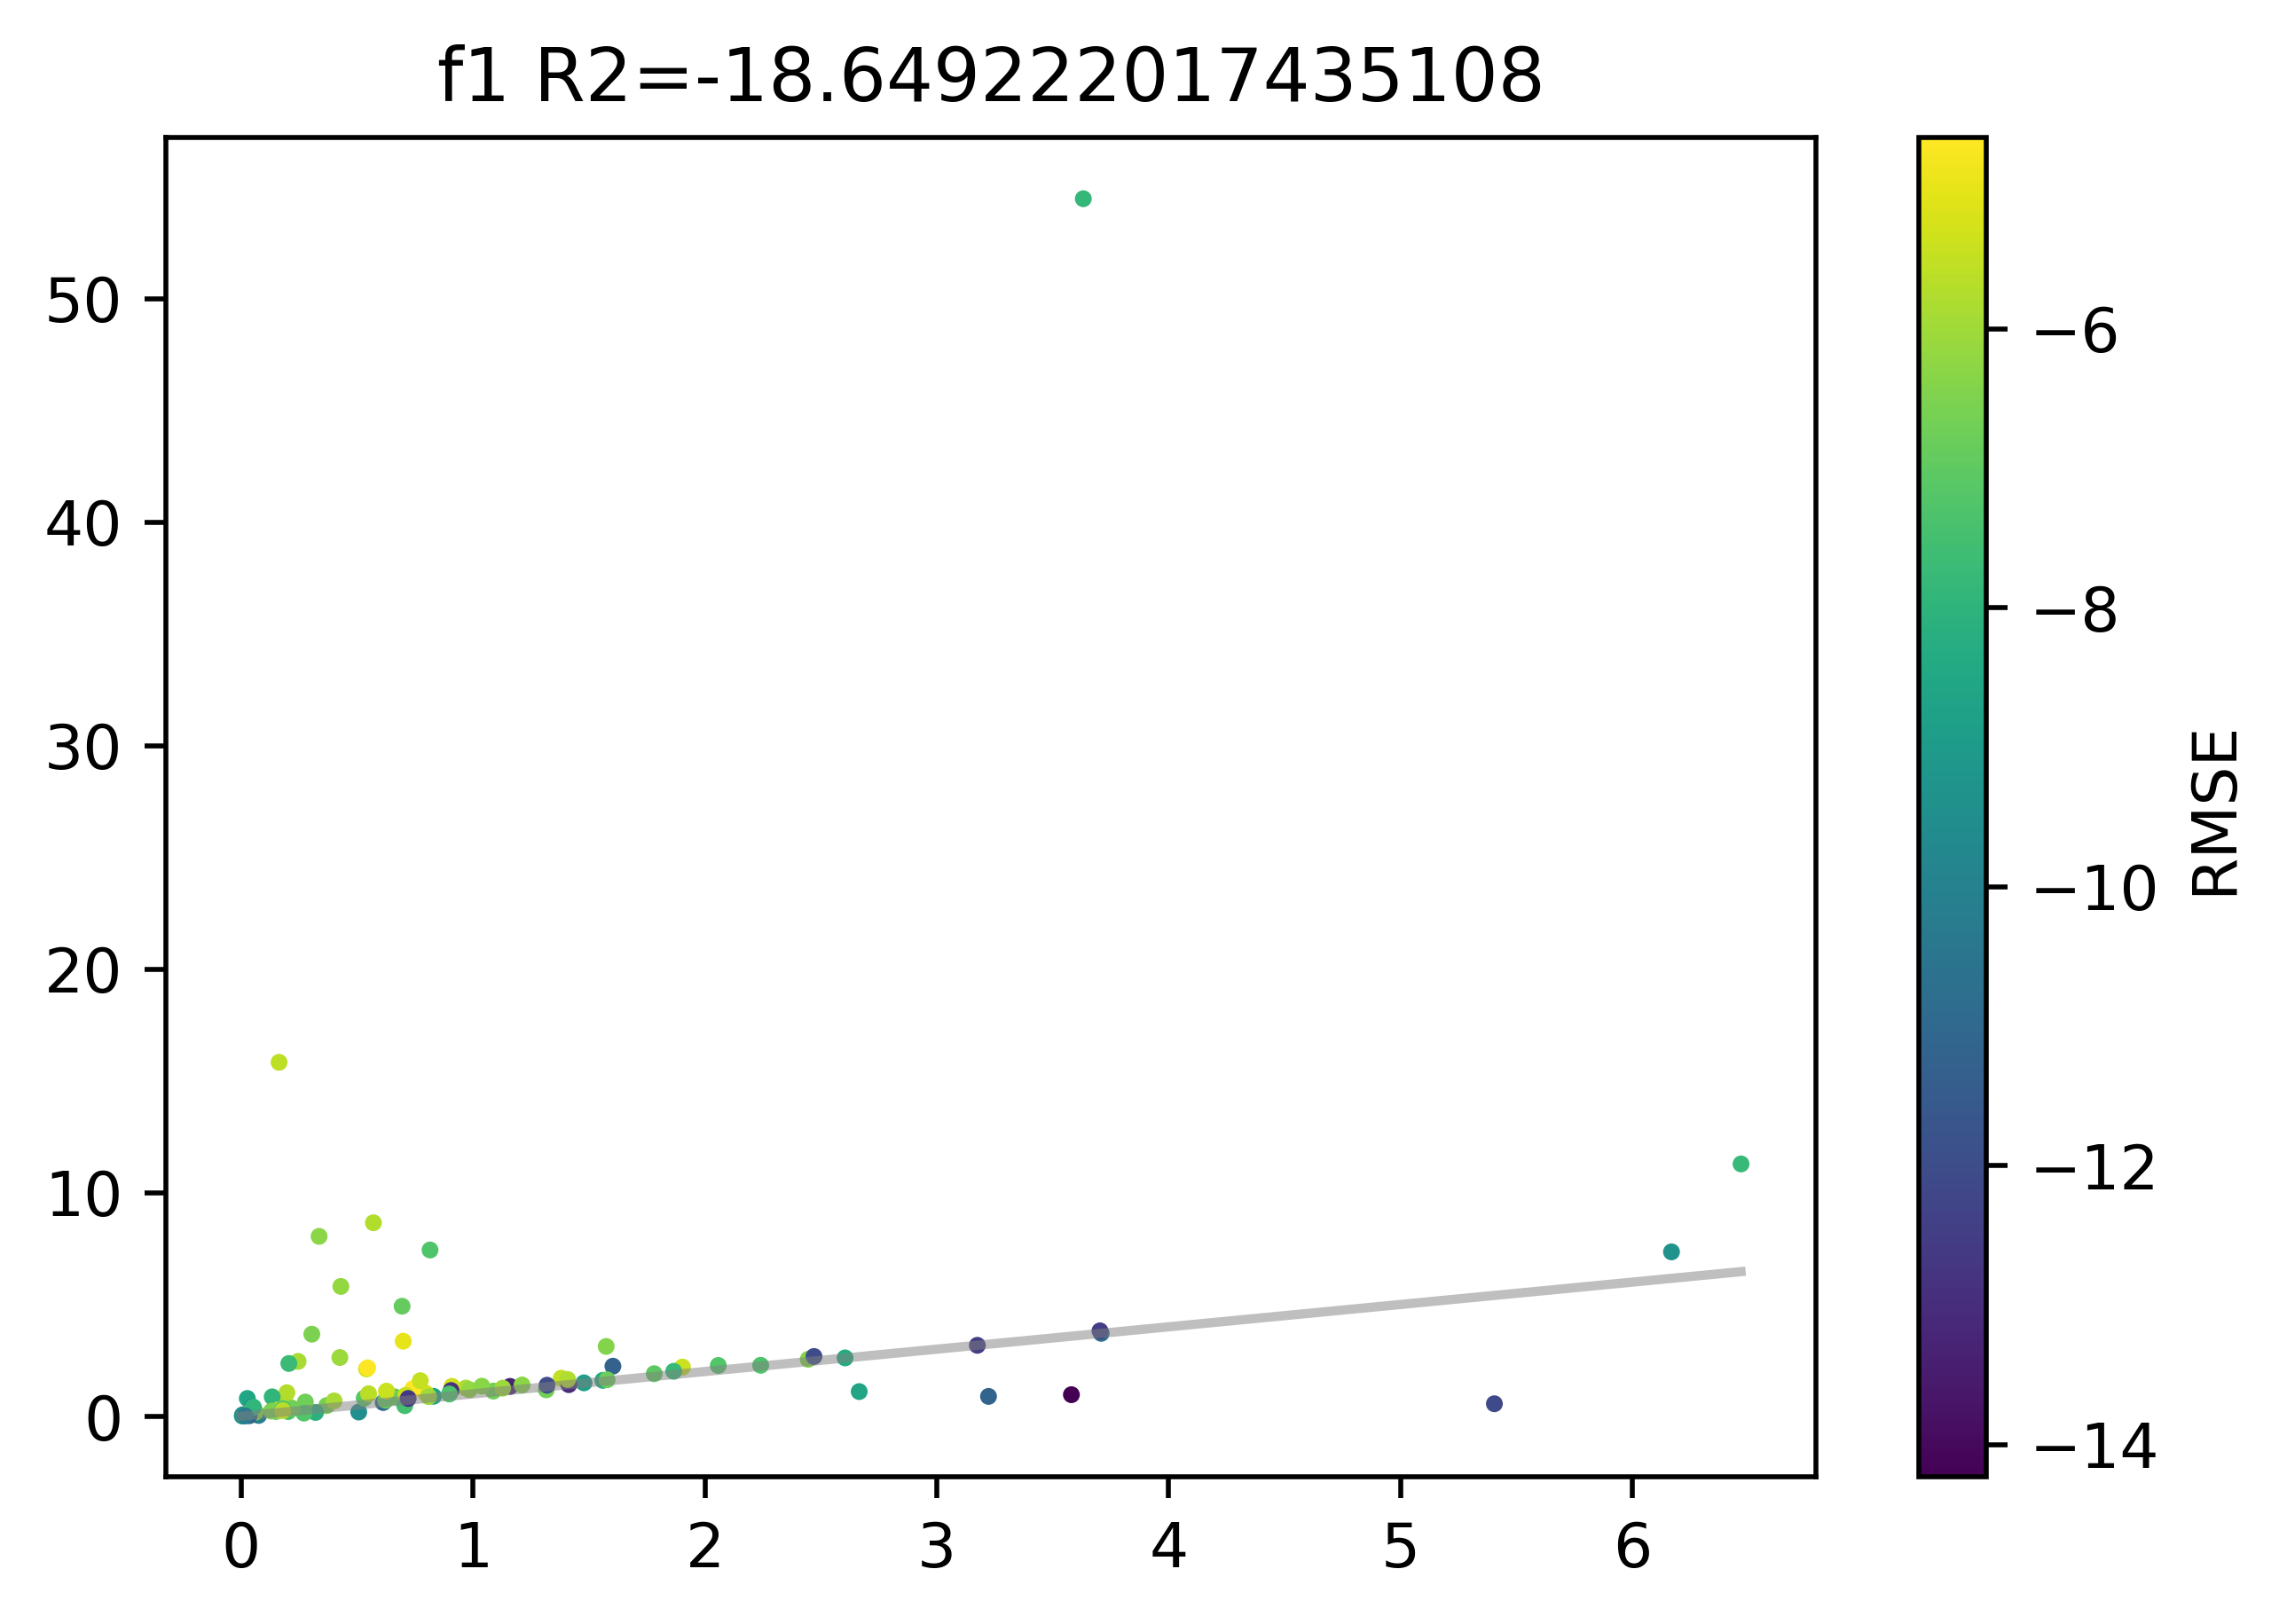

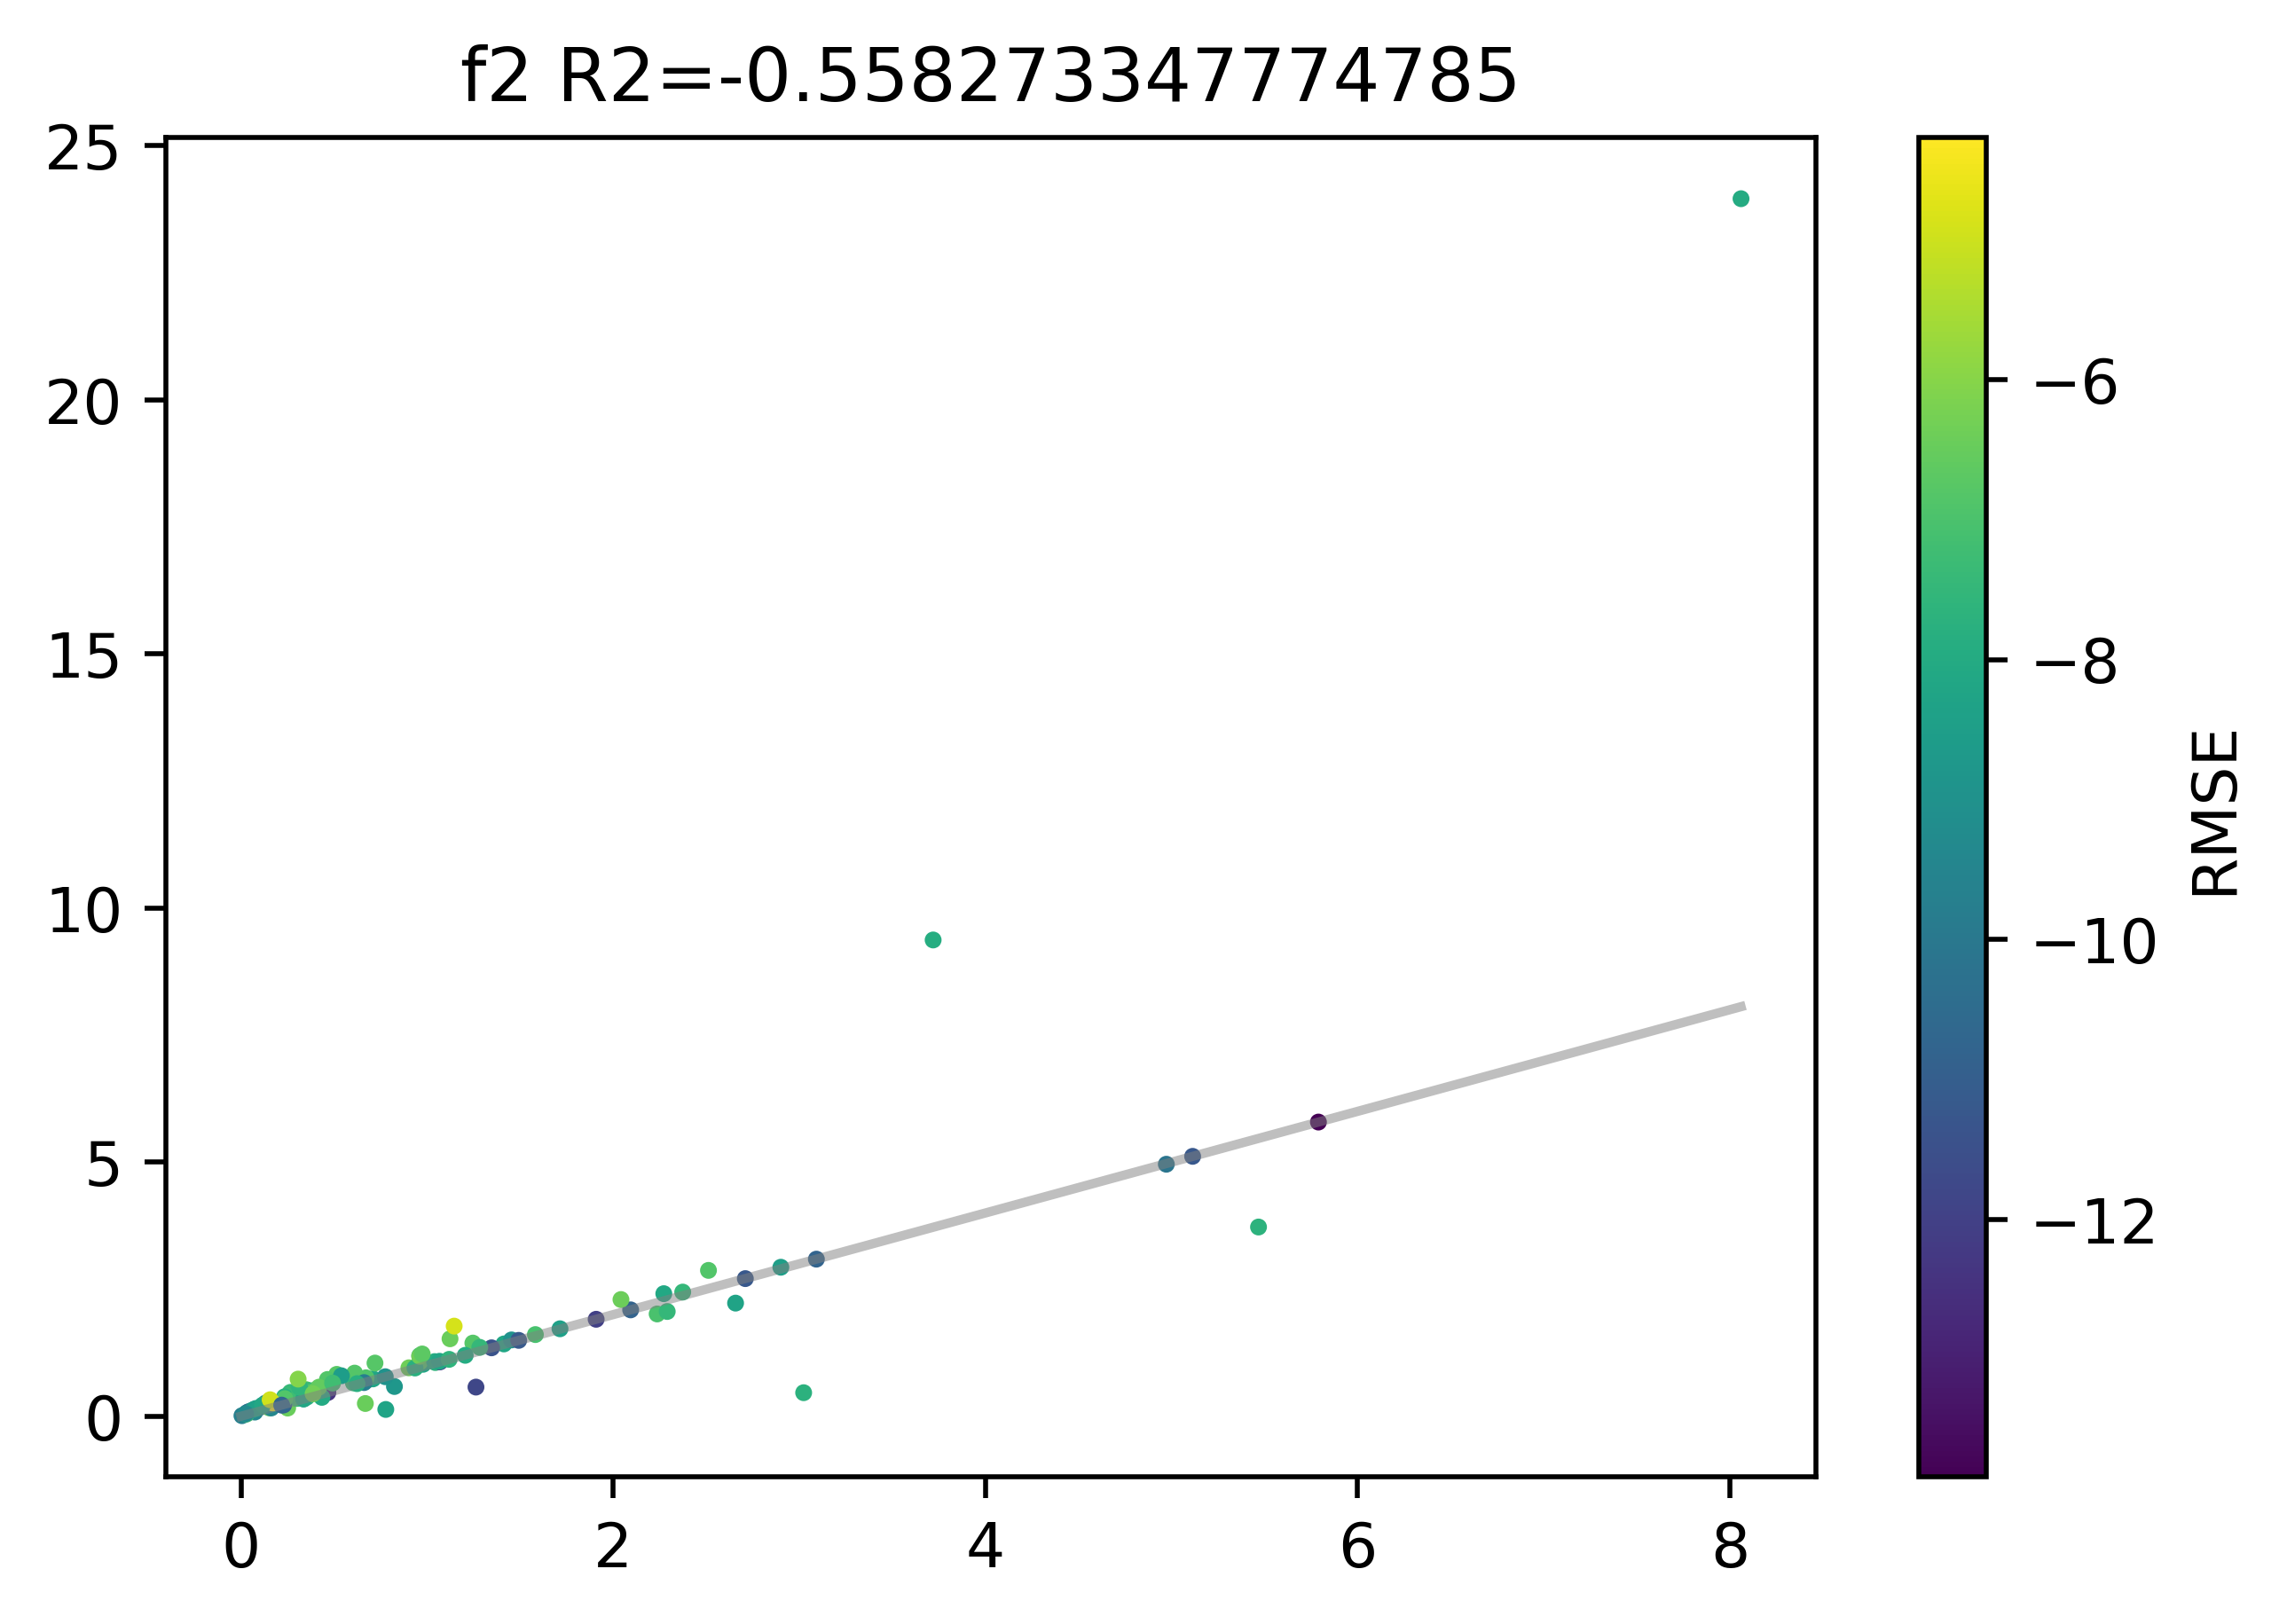

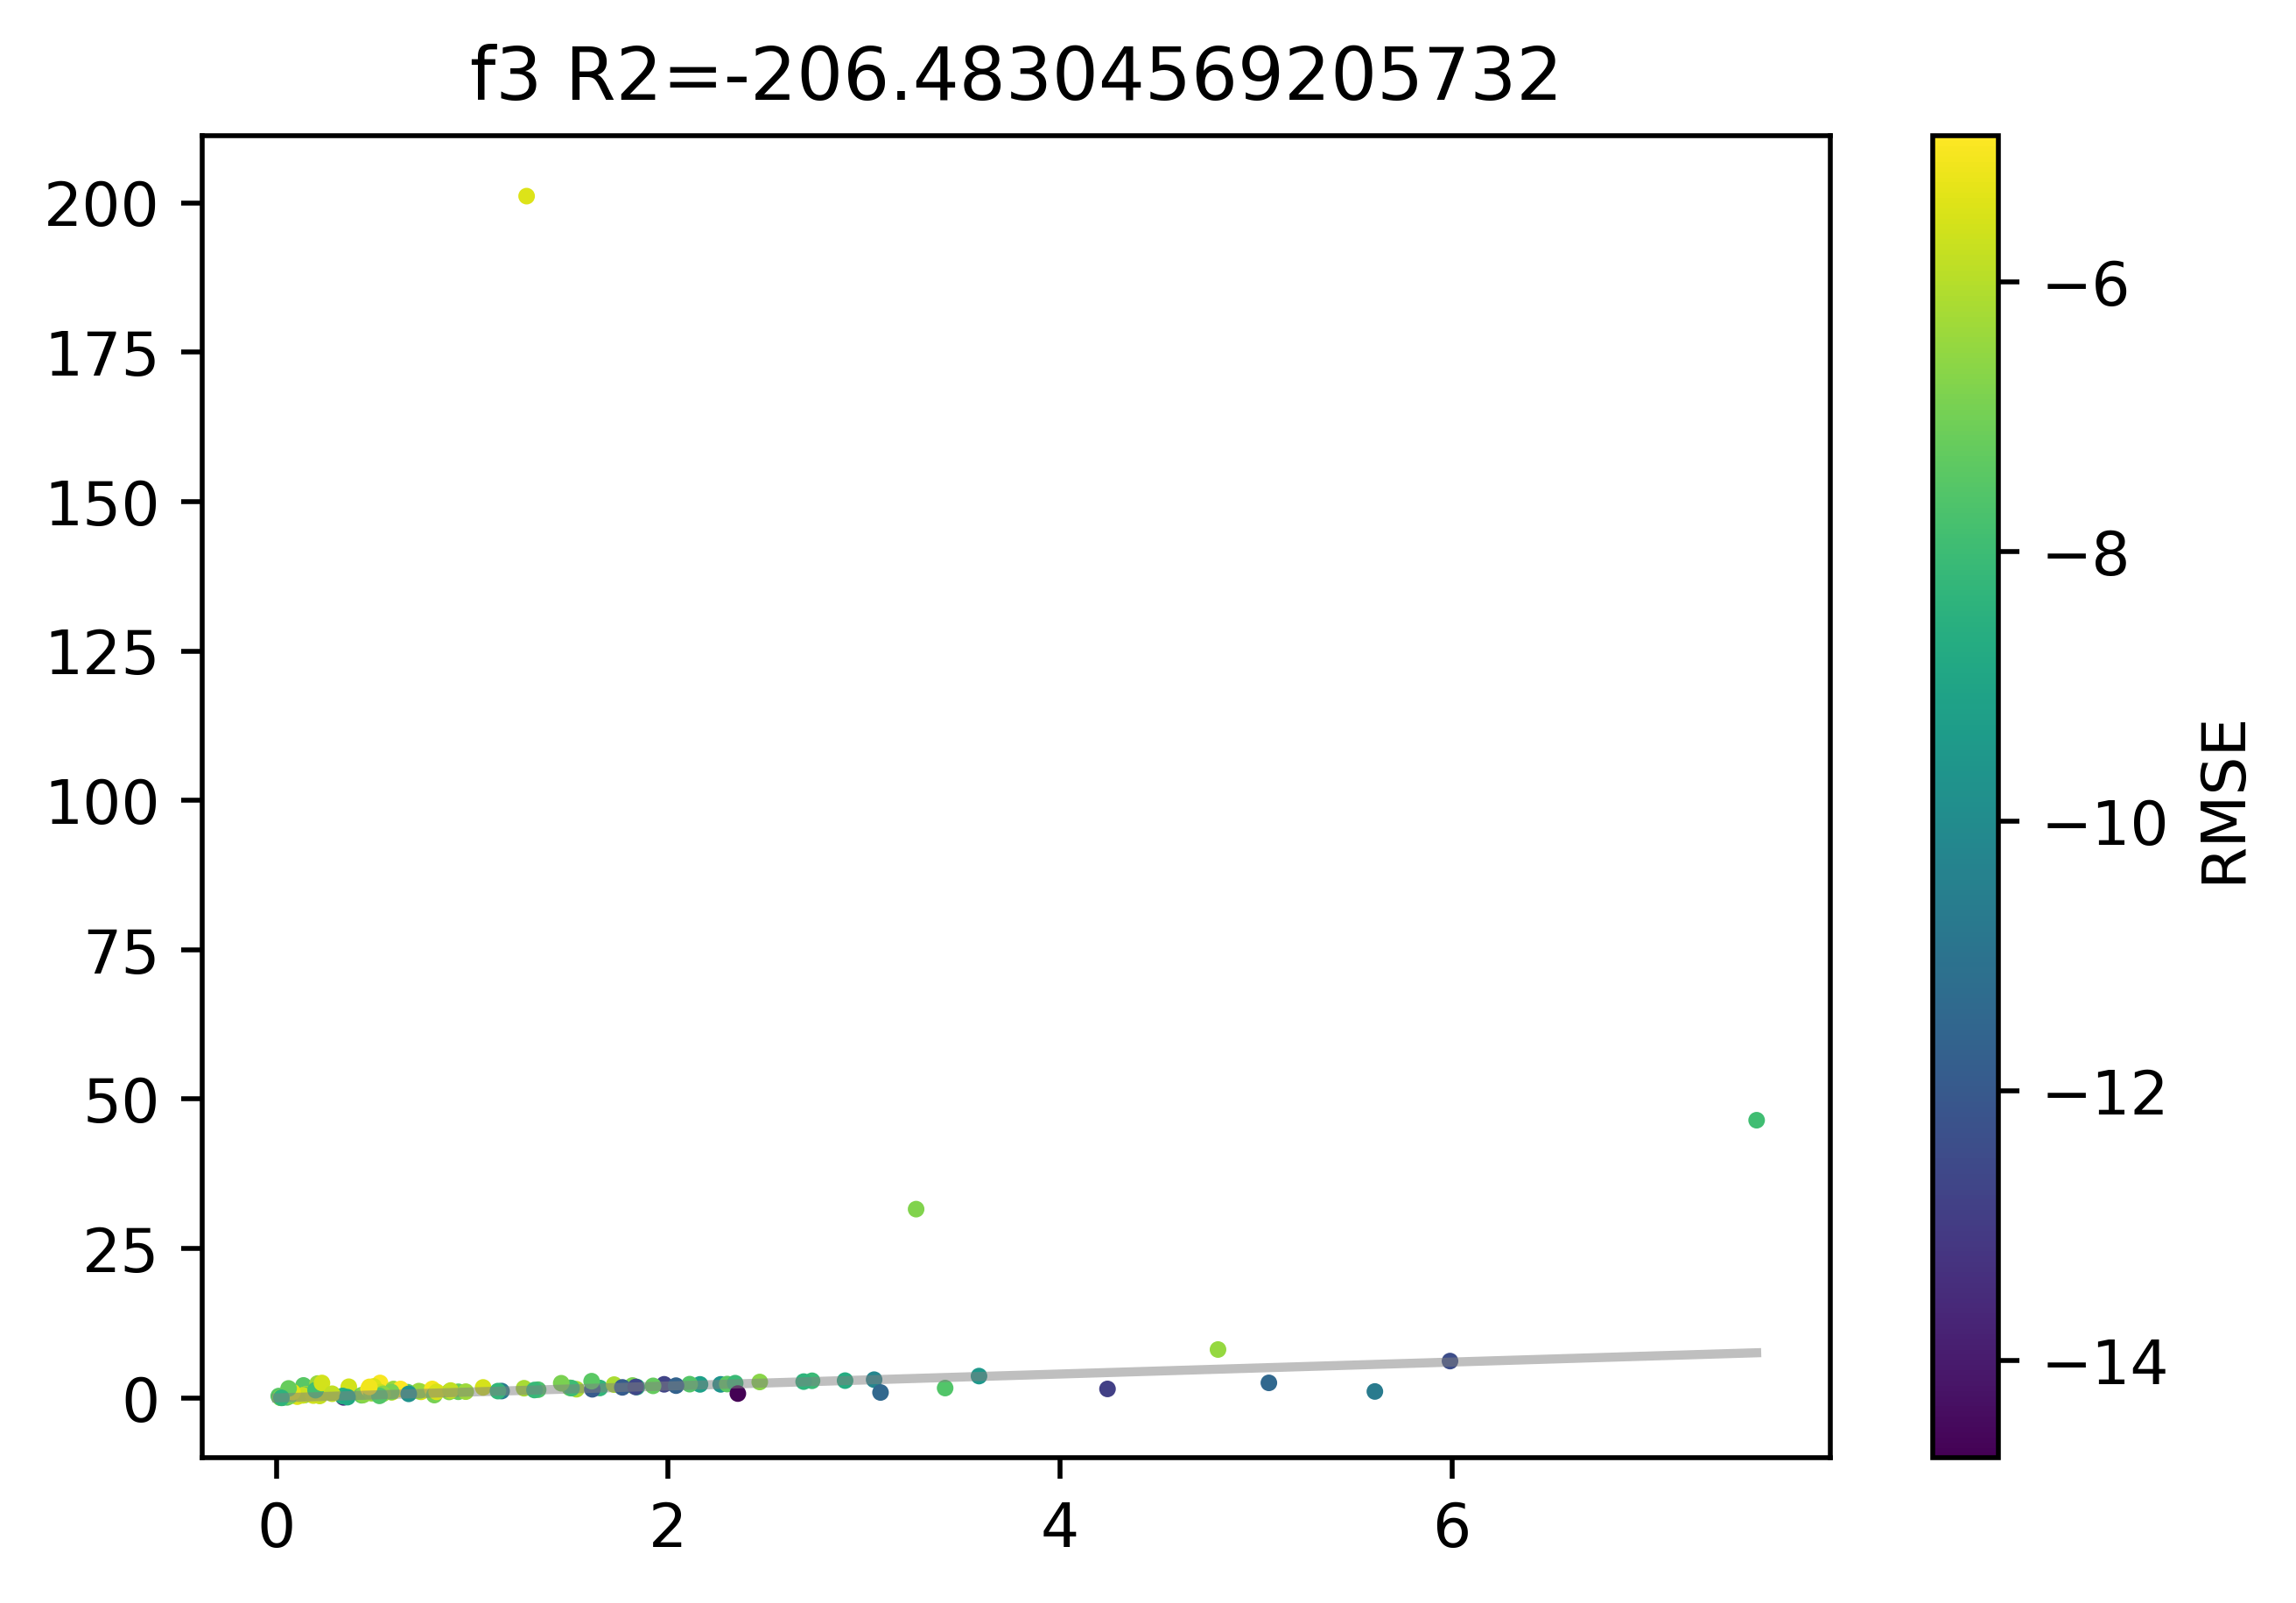

In [11]:
for x in range(pred.shape[1]):
    plt.figure()
    plt.scatter(true[:,x],pred[:,x],s=3,c=np.log10(err[:,x]))
    plt.plot([0,max(true[:,x])],[0,max(true[:,x])],color="grey",alpha=.5)
    plt.title("f" + str(x+1) + " R2=" + str(r2_score(true[:,x],pred[:,x])))
    plt.colorbar(label="RMSE")

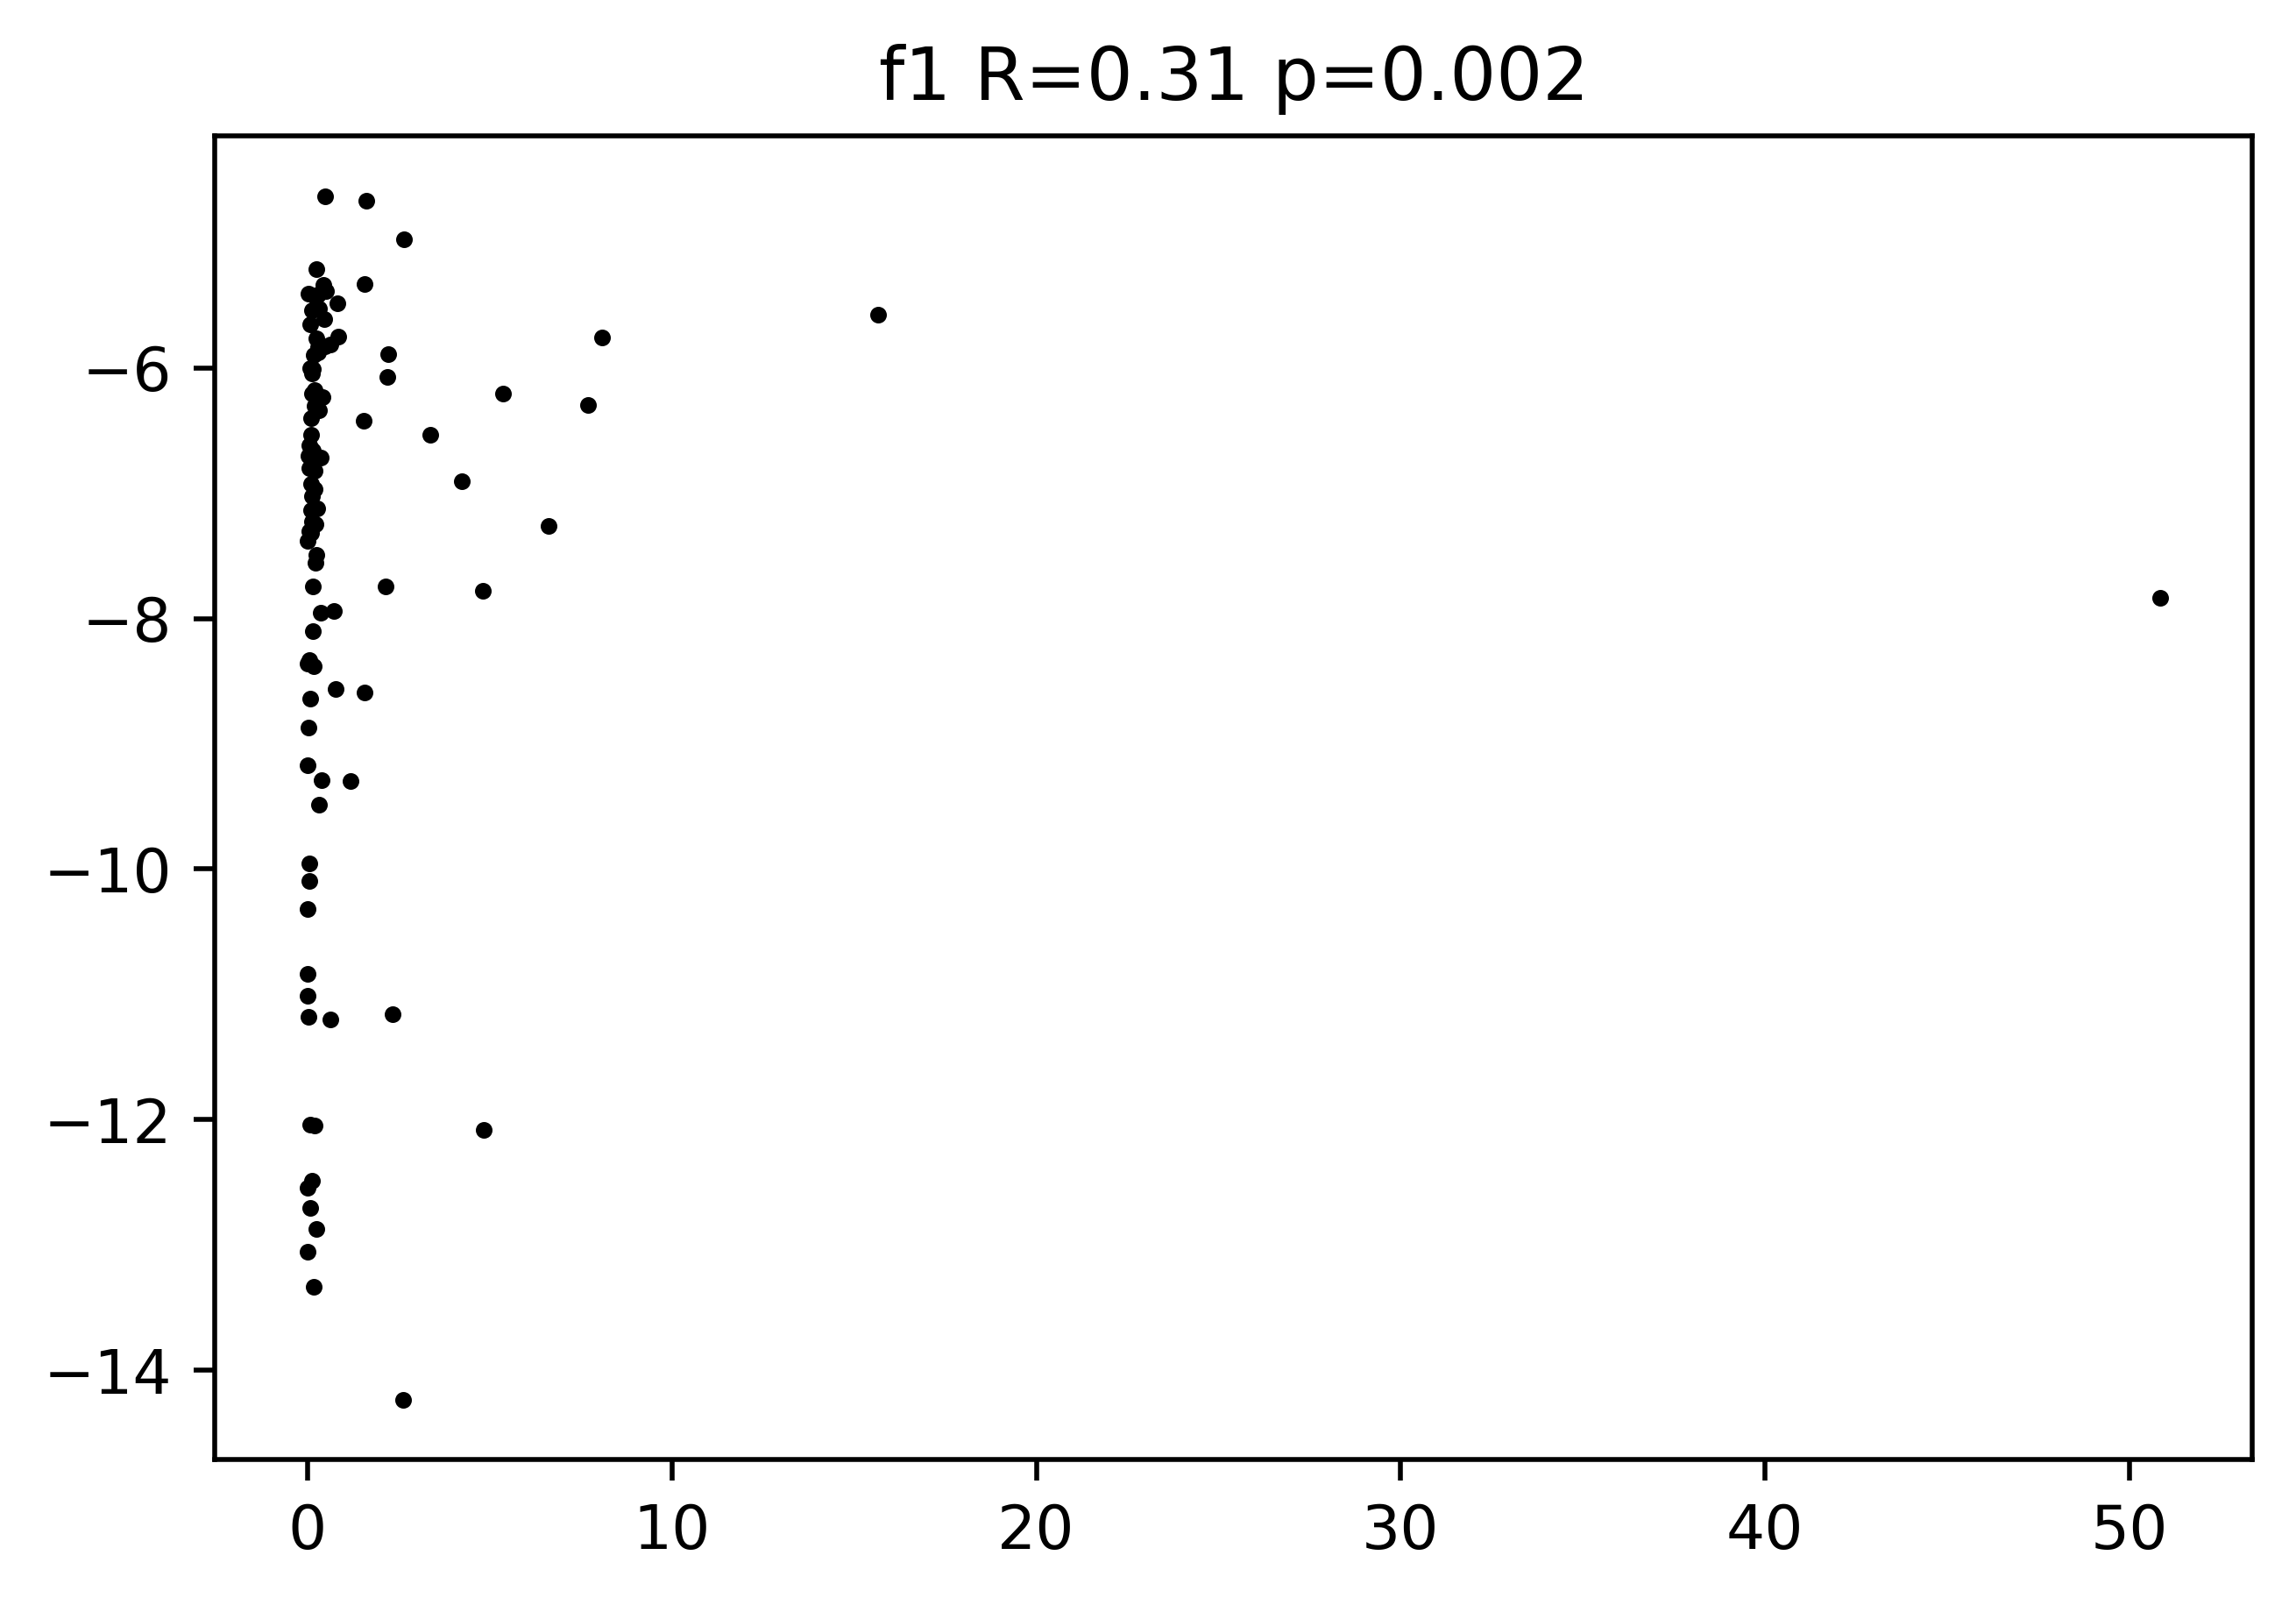

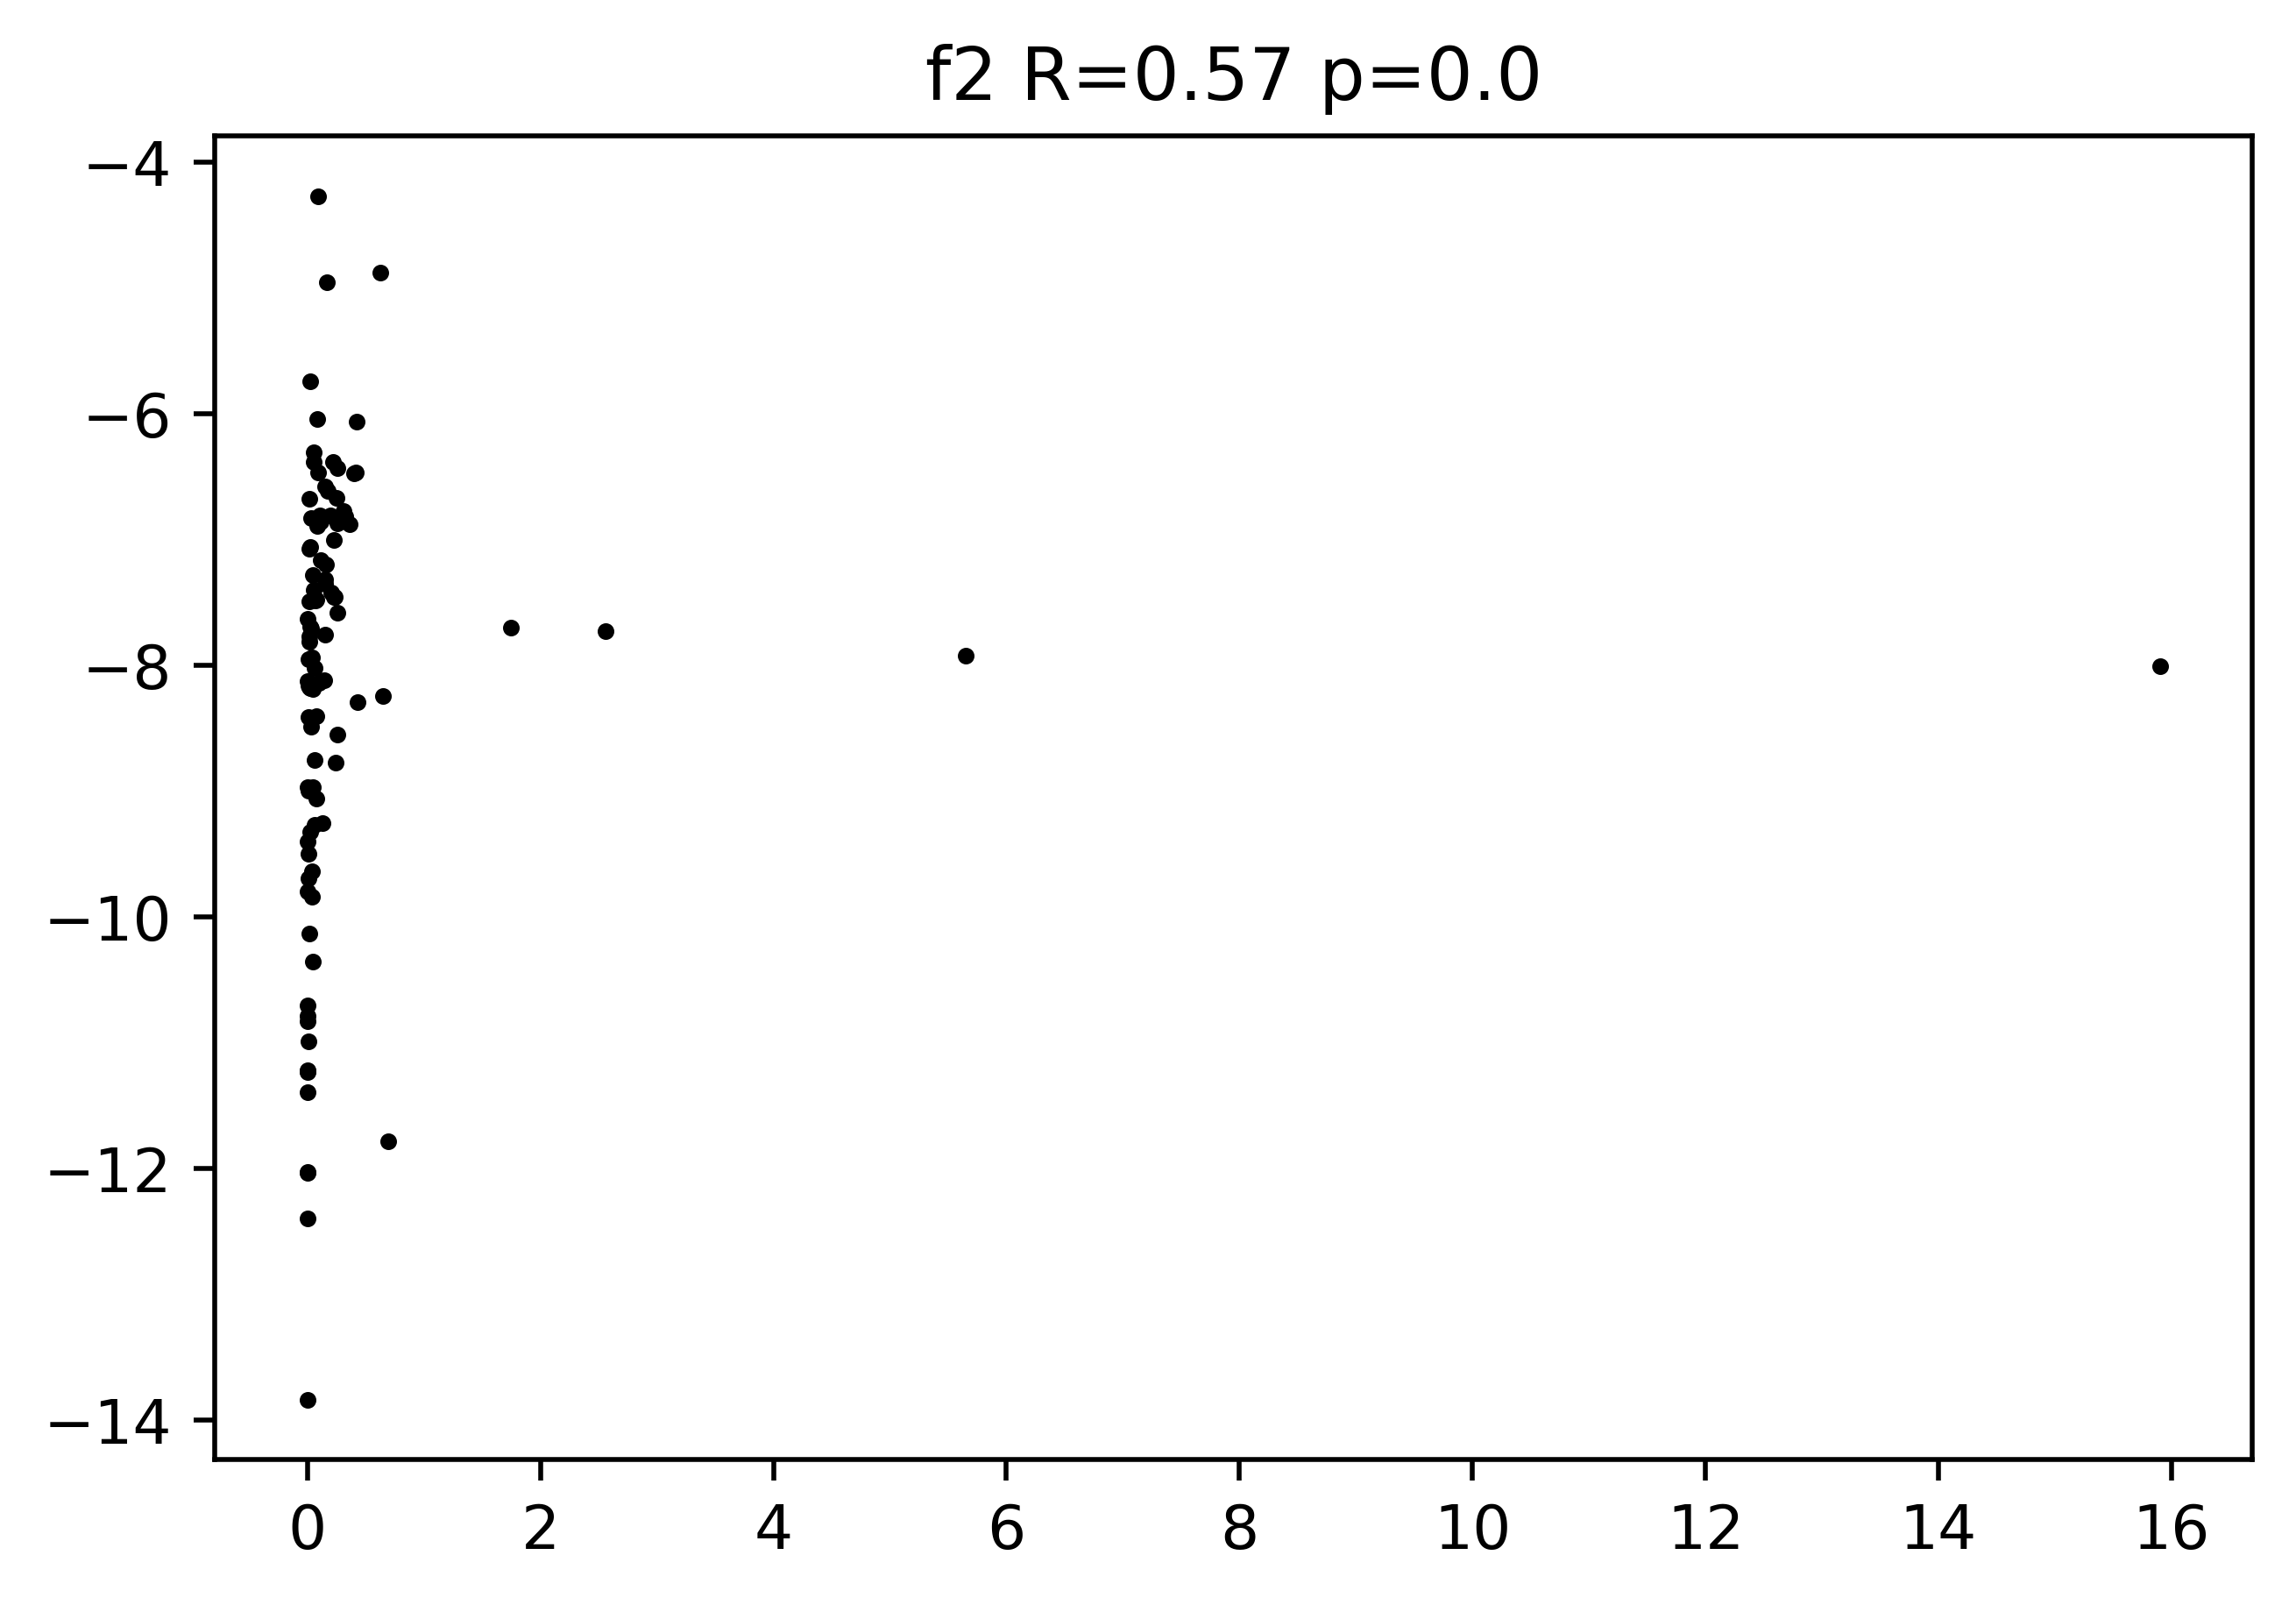

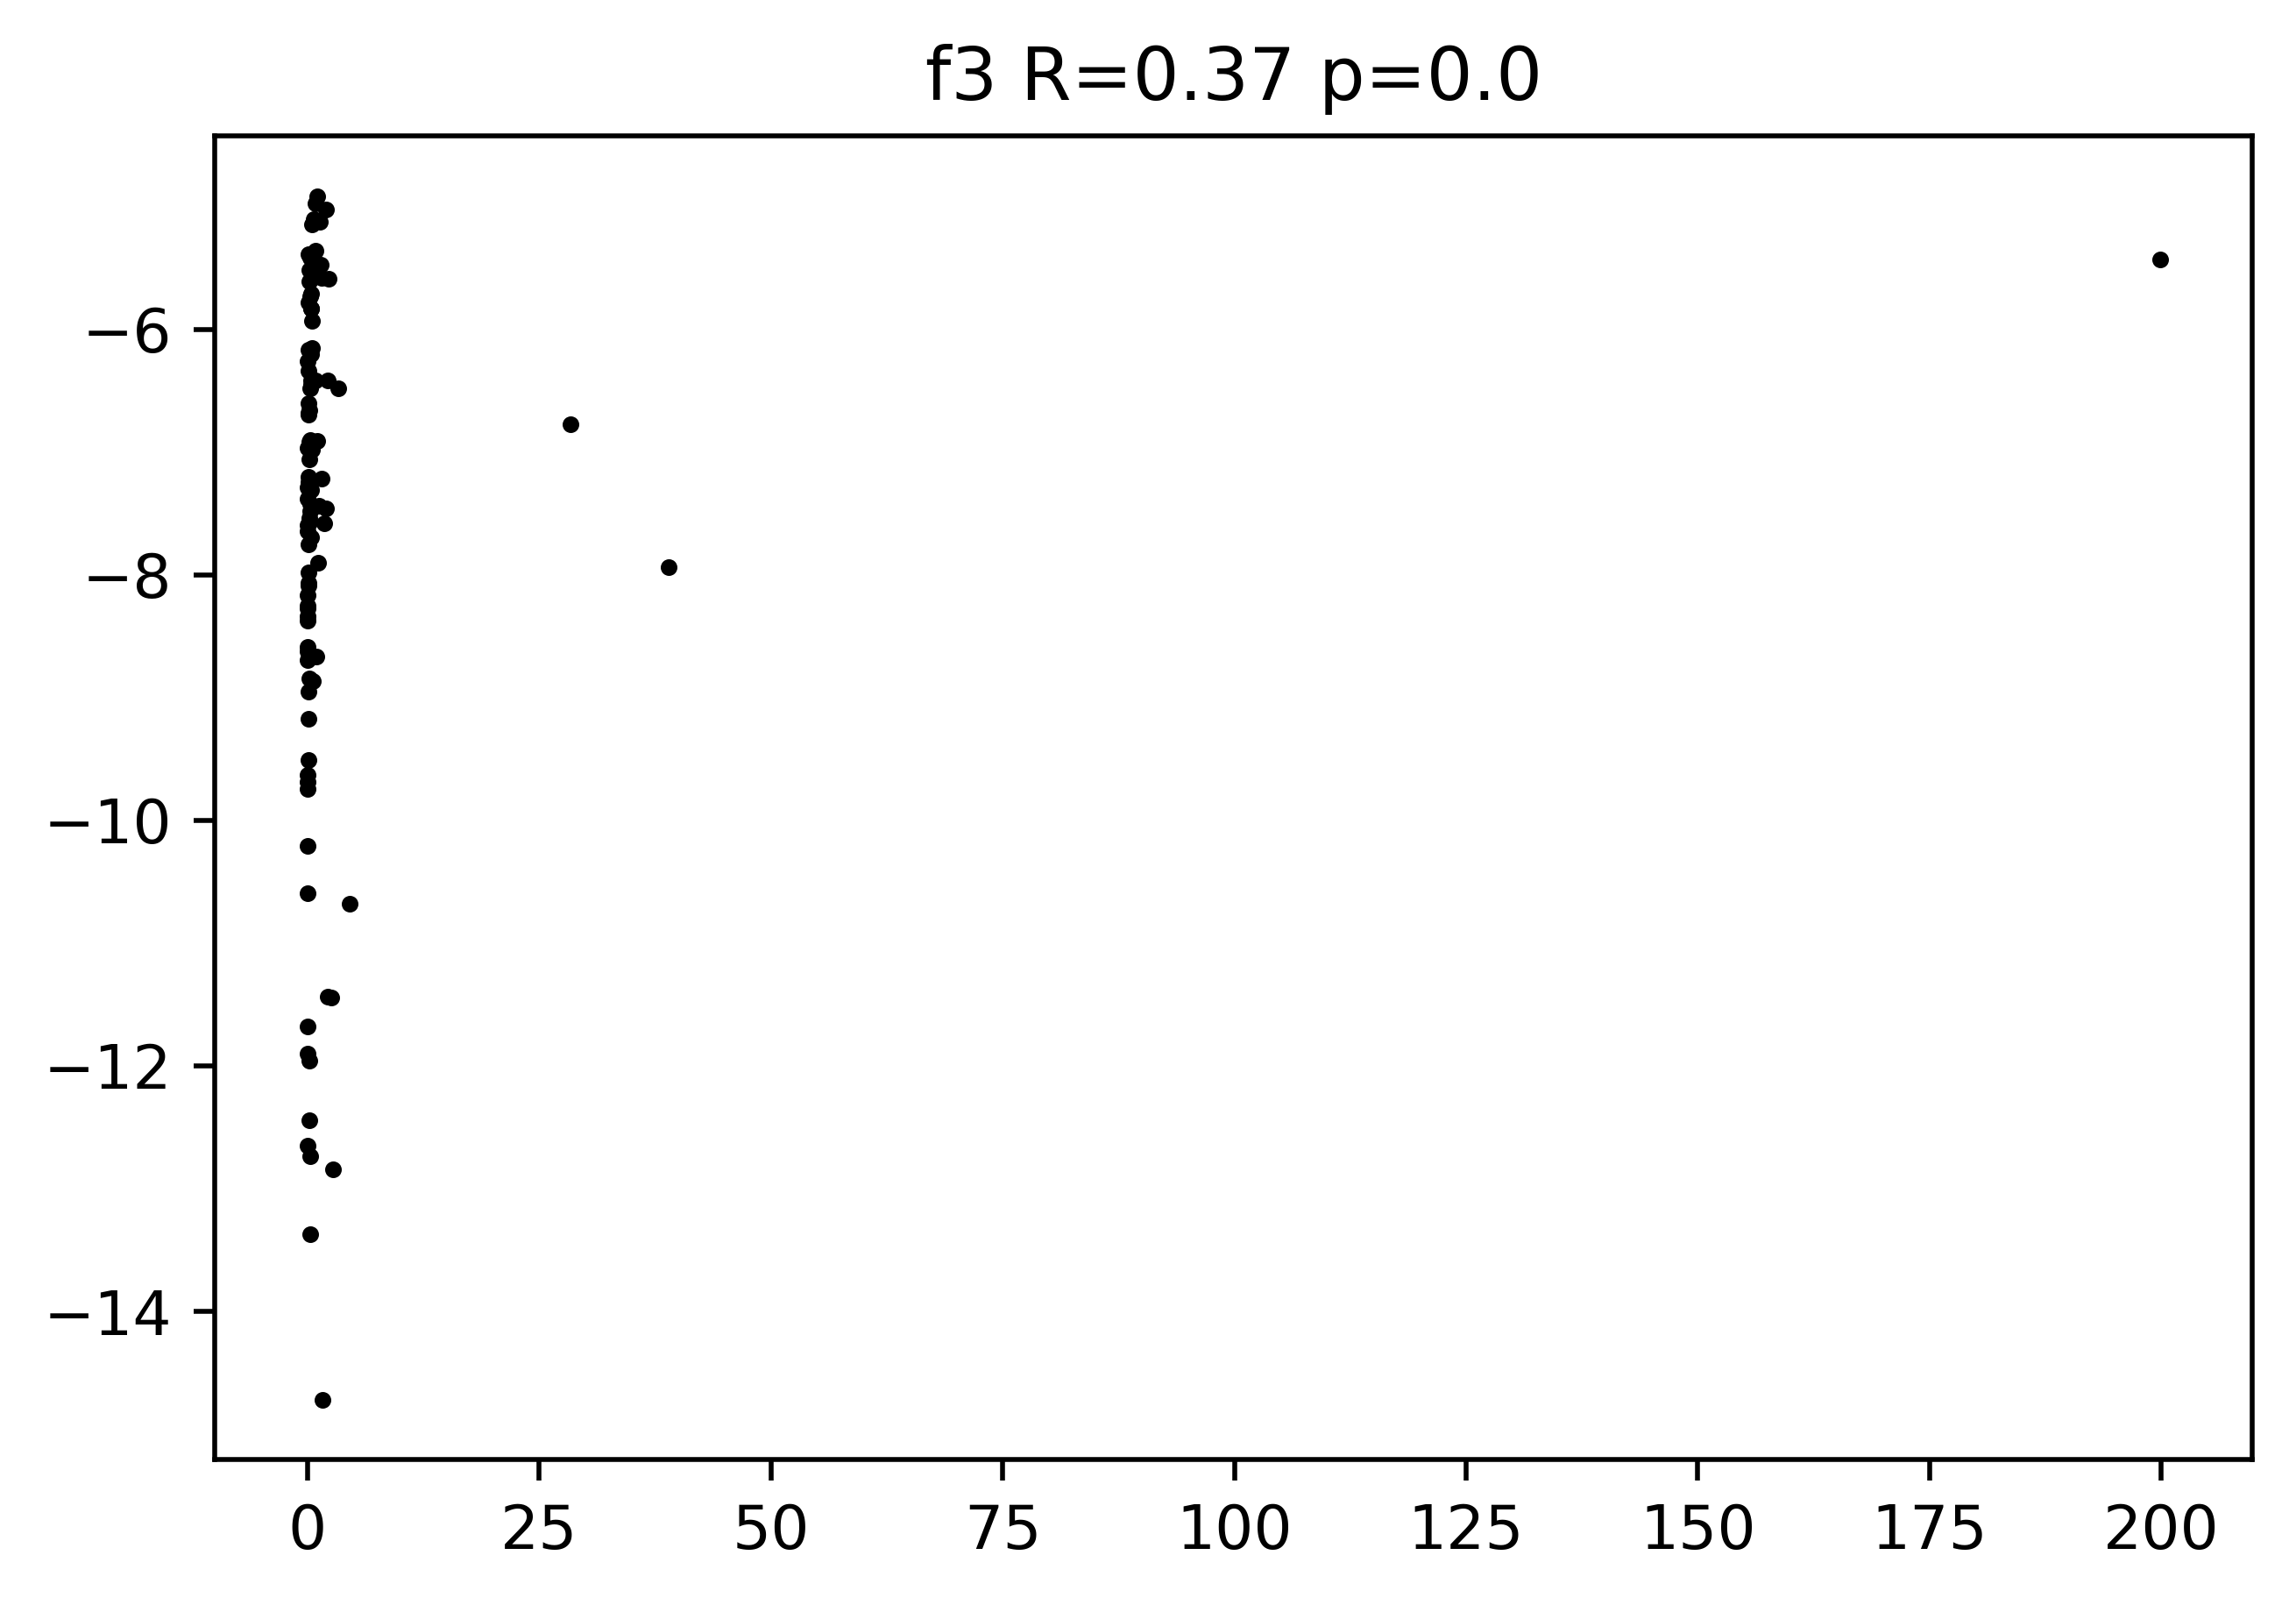

In [12]:
for x in range(pred.shape[1]):
    plt.figure()
    errs = np.abs(true[:,x]-pred[:,x])
    plt.scatter(errs,np.log10(err[:,x]),s=3,color="black")
    stat,p = stats.spearmanr(errs,err[:,x])
    plt.title("f" + str(x+1) + " R=" + str(np.round(stat,2)) + " p=" + str(np.round(p,3)))
